# CRISP-DM methodology applied in a real business case in Chile

**Table of Content** 

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

The main objective of this notebook is to represent the current status of the **Maintenance & Repair** division from the **OGC (Oil, Gas and Chemicals)** business line in **SGS Chile**, seeking to identify the main variables and the type of data that compose them, in order to extract preliminary information. 

[SGS](https://www.sgs.cl/en/) is one of the world's leading inspection, verification, testing and certification company. In Chile, the company is divided in four branches: SGS Chile, SGS Minerals, SGS Siga and SGS Academy; where each one of them is in charge of executing specific process and services. 

In order to achieve this purpose, the CRISP-DM methodology will be applied.

Due to the company policy and because it is real data, the information used here is two years old.

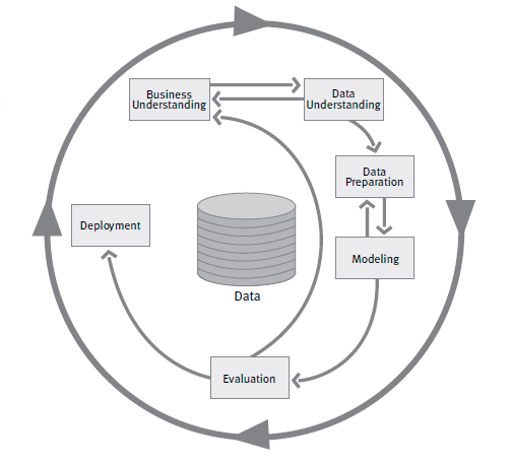

In [1]:
# The Cross-industry standard process for data mining methodology
from IPython.display import Image
Image(filename='../images/CRISP-DM.png', width=400, height=200)

# I. Business Understanding

The scope of this project will be reduced only to the Maintenance & Repair division(M&R), which belongs to the Oil, Gas and Chemicals business line (OGC)

In [2]:
# Import libraries

# General
import re, pickle, datetime, spacy, numpy as np, pandas as pd
from collections import Counter
from pprint import pprint
pd.options.display.max_columns = None  # Show all the columns from a df

# Warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter('ignore')
pd.options.mode.chained_assignment = None  # default='warn' ---> Not showing warnings about iloc

# Gensim
import gensim, gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis, pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.colors as mcolors

# Stop Words
with open('../data/stop_words_spanish.txt','r') as f:
    stop_words = f.read().splitlines()    # List of spanish stop words + some business stop words 

# NLP from Spacy
nlp = spacy.load('es_core_news_lg', disable=['parser', 'ner'])     # Spanish library
    
%matplotlib inline

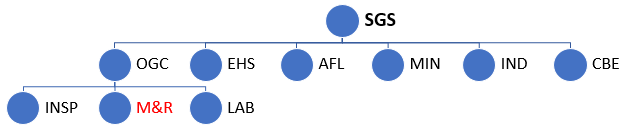

In [3]:
# Global view of the Maintenance & Repair (M&R) division in SGS Chile
Image(filename='../images/OGC_SGS.png', width=600, height=400)

The **Maintenance & Repair (M&R)** area is responsible for carrying out repairs, adjustments, installations and tests to the different components and equipment at the many service stations that are associated to the OGC business line, mostly gas stations.

To ensure proper control of activities, the **M&R** section uses a database that collects the details of each tasks performed by the workers.

In [135]:
# Get the data 
df = pd.read_excel("../data/List_Report_Gestion_30082019061320.xls")
df.head(5)

,Recepción OT,Hora Recep.,OT,Estacion,Tipo Estación,Ubicación Técnica,Origen del Servicio,Region,Prioridad SGS,Prioridad Cliente,Tecnico Asignado,Estado OT,Condición,Tipo de Falla,Observación,Requerimiento,Técnico Cierre,TDR,TDS,Fecha Arribo,Hora Arribo,Fecha Cierre,Hora Cierre,Cod. Repuesto,Repuesto,Cnt,Monto,Total,Ltr 93,Ltr 95,Ltr 97,Ltr D,Ltr K,Ind. Gestion
0,30/08/2019,17:18:00,3008190033,Buses Metropolitana,PUNTO INDUSTRIAL,2256194,Contrato Fuel System Enex,13°,Normal 24 Horas,Normal 24 Horas,Robinson Quiroz,PENDIENTE,ASIGNADA,OTRO,NaN,Area de Atención : Surtidor no marca correctam...,No Asignado,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
1,30/08/2019,17:17:00,3008190024,INVERSIONES INGERIASUR LTDA.,ESTACION DE SERVICIO,359,Contrato Fuel System Enex,9°,Normal 24 Horas,Normal 24 Horas,Antonio Lopez,PENDIENTE,ASIGNADA,OTRO,NaN,Area de Atención : TANQUES ENTERRADOS NO CUENT...,No Asignado,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
2,30/08/2019,16:52:00,2606190074,Tingaro Spa.,ESTACION DE SERVICIO,553,Contrato Fuel System Enex,13°,Normal 48 Horas,Normal 48 Horas,Juan Aliaga,CERRADA,NO APLICA,OTRO,Se cambia placa de TK 2 GAS95 por placa que in...,Area de Atención : HABILITAR ESTANQUE DE COMB...,No Asignado,-1543.8700,-47.8667,27/06/2019,09:00:00,28/08/2019,17:00:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
3,30/08/2019,16:49:00,3008190043,INVERSIONES GLOBAL LIMITADA,ESTACION DE SERVICIO,660,Contrato Fuel System Enex,9°,Normal 24 Horas,Normal 24 Horas,Antonio Lopez,PENDIENTE,ASIGNADA,OTRO,NaN,Area de Atención : Sin diesel Solicitado por: ...,No Asignado,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
4,30/08/2019,16:48:00,2908190028,Comercial Antuco Ltda.,ESTACION DE SERVICIO,680,Contrato Fuel System Enex,5°,Normal 24 Horas,Normal 24 Horas,Angello Gonzalez,ABIERTA,EN EJECUCION,OTRO,NaN,Area de Atención : pislota manquera cortada So...,No Asignado,-27.9667,0.0000,29/08/2019,12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN


In [5]:
# Shape of the DF
df.shape

(23258, 34)

In [6]:
# Get column names
df.columns

Index(['Recepción OT', 'Hora Recep.', 'OT', 'Estacion', 'Tipo Estación',
       'Ubicación Técnica', 'Origen del Servicio', 'Region', 'Prioridad SGS',
       'Prioridad Cliente', 'Tecnico Asignado', 'Estado OT', 'Condición',
       'Tipo de Falla', 'Observación', 'Requerimiento', 'Técnico Cierre',
       'TDR', 'TDS', 'Fecha Arribo', 'Hora Arribo', 'Fecha Cierre',
       'Hora Cierre', 'Cod. Repuesto', 'Repuesto', 'Cnt', 'Monto', 'Total',
       'Ltr 93', 'Ltr 95', 'Ltr 97', 'Ltr D', 'Ltr K', 'Ind. Gestion'],
      dtype='object')

To get a better undestanding about what the data means, the general process behind each record is described below:

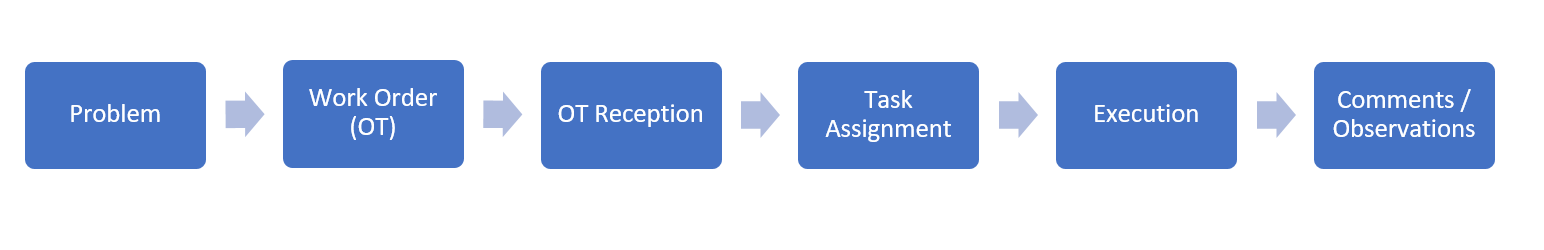

In [7]:
# General process of a work order (OT) in the M&R division
# OT means "Orden de Trabajo" which translated to Enlglish means Work Order 
Image(filename='../images/MYR_TASKFLOW.png', width=800, height=800)

**The normal process of a work order (OT) is:**

1. **Problem**: Service stations detect a problem or they noticed that maintenance is needed
2. **Work Order (OT)**: Because of the requirement, a work order (*Órden de Trabajo* in Spanish) is issued to the M&R
3. **OT Reception**: M&R analyze and prioritize the OT
4. **Task Assignment**: A qualified technician is chosen for working on the task according to his availability
5. **Execution**: Time that the worker spends on the task
6. **Comments/Observations**: Brief description of the task and what was done. The technician must do this step

In order to get a better understanding of the data, we will analyze the table based on three main questions 

<div class="alert alert-success" style="margin: 20px">
<b>Business Questions: </b><br>
    Q1.- What are the periods when M&R receives the most number of work orders (OT)? Is there a peak?<br>
    Q2.- How long does it take to attend the requests? and how much time does a worker spend fixing the issues?<br>
    Q3.- What are the most common type of failures or issues that require attention?  
</div>

# II. Data Understanding

The following is a brief description of each of the columns

In [8]:
# Schema - Columns names, its description and its translation
schema = pd.read_excel("../data/Data_Schema.xls")
schema

,Columna,Descripción,English_Translation
0,Recepción OT,Fecha en que la OT ingresa al sistema,Date when the OT enters to the system
1,Hora Recep.,Hora en que la OT ingresa al sistema,Time when the OT enters to the system
2,OT,Código de la OT,OT Code
3,Estacion,Nombre de estación de servicio,Name of the service station
4,Tipo Estación,Tipo de estación de servicio,Type of the service station
5,Ubicación Técnica,Localización de la estación de servicio,Location of the service station
6,Origen del Servicio,Rubro de la estación,Origin and field of the station
7,Region,Región geográfica en donde está la estación,Geographic region where the station is located
8,Prioridad SGS,Nivel de urgencia de la OT de acuerdo a M&R,OT urgency level according to M&R
9,Prioridad Cliente,Nivel de urgencia de la OT de acuerdo al cliente,OT urgency level according to the client


In [9]:
# Renaming columns for a better usage, replacing spanish characters (like accents) for standard letters
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
new_cols = (df.columns
              .str.replace('\s+', '_')
              .str.replace('.', '')
              .str.lower()
              .str.normalize('NFKD')
              .str.encode('ascii', errors='ignore')
              .str.decode('utf-8'))

df.columns = new_cols

<>:5: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \s
<ipython-input-9-e19986aad845>:5: DeprecationWarning: invalid escape sequence \s
  .str.replace('\s+', '_')


In [10]:
df.columns

Index(['recepcion_ot', 'hora_recep', 'ot', 'estacion', 'tipo_estacion',
       'ubicacion_tecnica', 'origen_del_servicio', 'region', 'prioridad_sgs',
       'prioridad_cliente', 'tecnico_asignado', 'estado_ot', 'condicion',
       'tipo_de_falla', 'observacion', 'requerimiento', 'tecnico_cierre',
       'tdr', 'tds', 'fecha_arribo', 'hora_arribo', 'fecha_cierre',
       'hora_cierre', 'cod_repuesto', 'repuesto', 'cnt', 'monto', 'total',
       'ltr_93', 'ltr_95', 'ltr_97', 'ltr_d', 'ltr_k', 'ind_gestion'],
      dtype='object')

In [11]:
# Data frame with standard columns names
df.head(5)

,recepcion_ot,hora_recep,ot,estacion,tipo_estacion,ubicacion_tecnica,origen_del_servicio,region,prioridad_sgs,prioridad_cliente,tecnico_asignado,estado_ot,condicion,tipo_de_falla,observacion,requerimiento,tecnico_cierre,tdr,tds,fecha_arribo,hora_arribo,fecha_cierre,hora_cierre,cod_repuesto,repuesto,cnt,monto,total,ltr_93,ltr_95,ltr_97,ltr_d,ltr_k,ind_gestion
0,30/08/2019,17:18:00,3008190033,Buses Metropolitana,PUNTO INDUSTRIAL,2256194,Contrato Fuel System Enex,13°,Normal 24 Horas,Normal 24 Horas,Robinson Quiroz,PENDIENTE,ASIGNADA,OTRO,NaN,Area de Atención : Surtidor no marca correctam...,No Asignado,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
1,30/08/2019,17:17:00,3008190024,INVERSIONES INGERIASUR LTDA.,ESTACION DE SERVICIO,359,Contrato Fuel System Enex,9°,Normal 24 Horas,Normal 24 Horas,Antonio Lopez,PENDIENTE,ASIGNADA,OTRO,NaN,Area de Atención : TANQUES ENTERRADOS NO CUENT...,No Asignado,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
2,30/08/2019,16:52:00,2606190074,Tingaro Spa.,ESTACION DE SERVICIO,553,Contrato Fuel System Enex,13°,Normal 48 Horas,Normal 48 Horas,Juan Aliaga,CERRADA,NO APLICA,OTRO,Se cambia placa de TK 2 GAS95 por placa que in...,Area de Atención : HABILITAR ESTANQUE DE COMB...,No Asignado,-1543.8700,-47.8667,27/06/2019,09:00:00,28/08/2019,17:00:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
3,30/08/2019,16:49:00,3008190043,INVERSIONES GLOBAL LIMITADA,ESTACION DE SERVICIO,660,Contrato Fuel System Enex,9°,Normal 24 Horas,Normal 24 Horas,Antonio Lopez,PENDIENTE,ASIGNADA,OTRO,NaN,Area de Atención : Sin diesel Solicitado por: ...,No Asignado,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
4,30/08/2019,16:48:00,2908190028,Comercial Antuco Ltda.,ESTACION DE SERVICIO,680,Contrato Fuel System Enex,5°,Normal 24 Horas,Normal 24 Horas,Angello Gonzalez,ABIERTA,EN EJECUCION,OTRO,NaN,Area de Atención : pislota manquera cortada So...,No Asignado,-27.9667,0.0000,29/08/2019,12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN


In [12]:
# Nulls values - Proportion
df.isnull().mean()

recepcion_ot           0.000000
hora_recep             0.000000
ot                     0.044888
estacion               0.000000
tipo_estacion          0.113681
ubicacion_tecnica      0.000000
origen_del_servicio    0.000000
region                 0.000000
prioridad_sgs          0.309012
prioridad_cliente      0.000000
tecnico_asignado       0.000000
estado_ot              0.000000
condicion              0.000000
tipo_de_falla          0.000000
observacion            0.060968
requerimiento          0.000000
tecnico_cierre         0.000000
tdr                    0.000000
tds                    0.000000
fecha_arribo           0.068020
hora_arribo            0.068020
fecha_cierre           0.083971
hora_cierre            0.083971
cod_repuesto           1.000000
repuesto               1.000000
cnt                    1.000000
monto                  1.000000
total                  1.000000
ltr_93                 0.000000
ltr_95                 0.000000
ltr_97                 0.000000
ltr_d   

In [13]:
# Unique values
for col in df.columns:
    print(f"{col:20} {len(df[col].unique()):7}")

recepcion_ot             350
hora_recep               768
ot                     22208
estacion                1007
tipo_estacion              3
ubicacion_tecnica       1164
origen_del_servicio        8
region                    15
prioridad_sgs             15
prioridad_cliente         14
tecnico_asignado          79
estado_ot                  4
condicion                 12
tipo_de_falla             66
observacion            18516
requerimiento          17070
tecnico_cierre            75
tdr                     8991
tds                    10379
fecha_arribo             462
hora_arribo             1289
fecha_cierre             455
hora_cierre             1231
cod_repuesto               1
repuesto                   1
cnt                        1
monto                      1
total                      1
ltr_93                   434
ltr_95                   262
ltr_97                   346
ltr_d                    394
ltr_k                    104
ind_gestion                4


According to the standards, it would be best to eliminate those columns that have 100% of their data null, or at least not to consider them in the analysis.

In [14]:
# Dropping columns that are 100% null 
df.drop(['cod_repuesto','repuesto','cnt','monto','total'], axis=1, inplace=True)

In [15]:
# Checking our df without the null columns 
df.head(3)

,recepcion_ot,hora_recep,ot,estacion,tipo_estacion,ubicacion_tecnica,origen_del_servicio,region,prioridad_sgs,prioridad_cliente,tecnico_asignado,estado_ot,condicion,tipo_de_falla,observacion,requerimiento,tecnico_cierre,tdr,tds,fecha_arribo,hora_arribo,fecha_cierre,hora_cierre,ltr_93,ltr_95,ltr_97,ltr_d,ltr_k,ind_gestion
0,30/08/2019,17:18:00,3008190033,Buses Metropolitana,PUNTO INDUSTRIAL,2256194,Contrato Fuel System Enex,13°,Normal 24 Horas,Normal 24 Horas,Robinson Quiroz,PENDIENTE,ASIGNADA,OTRO,NaN,Area de Atención : Surtidor no marca correctam...,No Asignado,0.00,0.0000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
1,30/08/2019,17:17:00,3008190024,INVERSIONES INGERIASUR LTDA.,ESTACION DE SERVICIO,359,Contrato Fuel System Enex,9°,Normal 24 Horas,Normal 24 Horas,Antonio Lopez,PENDIENTE,ASIGNADA,OTRO,NaN,Area de Atención : TANQUES ENTERRADOS NO CUENT...,No Asignado,0.00,0.0000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
2,30/08/2019,16:52:00,2606190074,Tingaro Spa.,ESTACION DE SERVICIO,553,Contrato Fuel System Enex,13°,Normal 48 Horas,Normal 48 Horas,Juan Aliaga,CERRADA,NO APLICA,OTRO,Se cambia placa de TK 2 GAS95 por placa que in...,Area de Atención : HABILITAR ESTANQUE DE COMB...,No Asignado,-1543.87,-47.8667,27/06/2019,09:00:00,28/08/2019,17:00:00,0.0,0.0,0.0,0.0,0.0,NaN


In [16]:
df.shape

(23258, 29)

In [17]:
# Categorical columns
cat_df = df.select_dtypes(include=['object'])
cat_df.columns

Index(['recepcion_ot', 'hora_recep', 'ot', 'estacion', 'tipo_estacion',
       'ubicacion_tecnica', 'origen_del_servicio', 'region', 'prioridad_sgs',
       'prioridad_cliente', 'tecnico_asignado', 'estado_ot', 'condicion',
       'tipo_de_falla', 'observacion', 'requerimiento', 'tecnico_cierre',
       'fecha_arribo', 'hora_arribo', 'fecha_cierre', 'hora_cierre',
       'ind_gestion'],
      dtype='object')

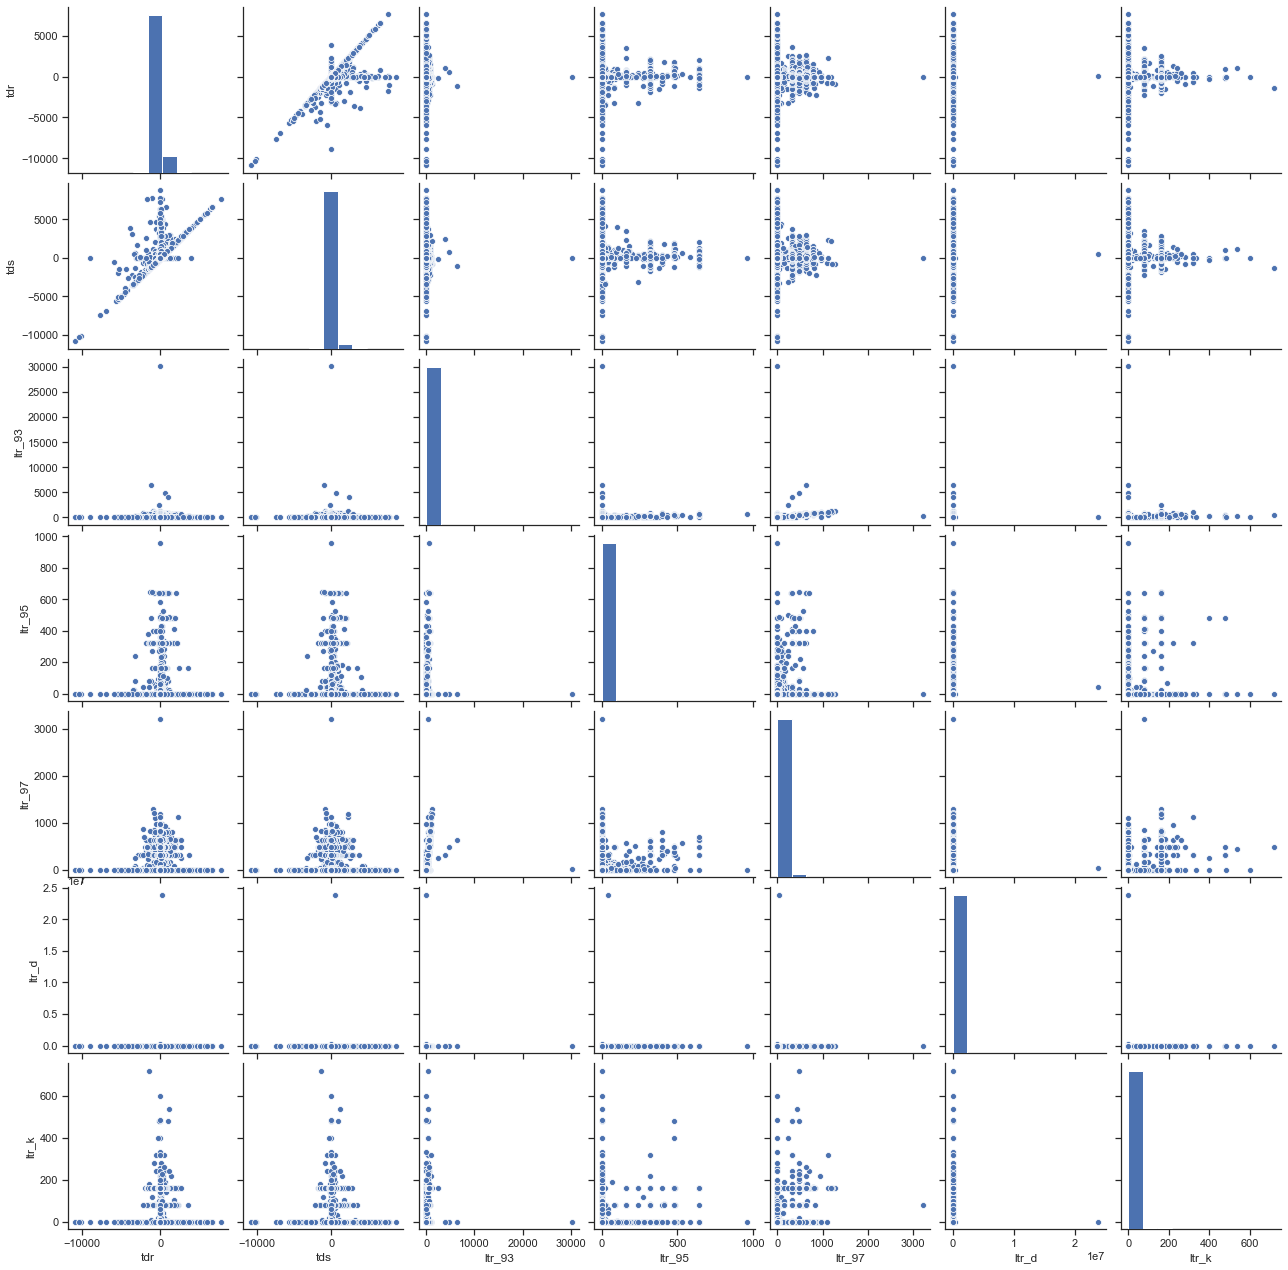

In [18]:
# Correlation between numerical variables by using the sns pairplot
sns.set(style='ticks')
sns.pairplot(df);

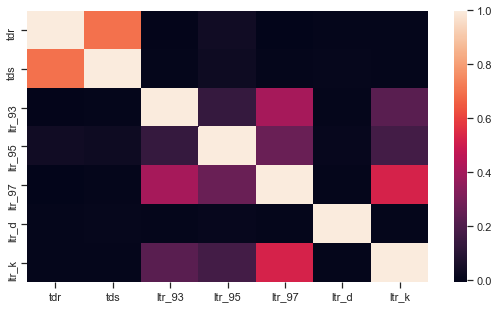

In [19]:
# Correlation between numerical variables by using the sns heatmap
plt.figure(figsize=(9,5))
corrs = df.corr()
sns.heatmap(corrs);

From the graphs above we can see that there is a slight correlation (0.2 < x <0.5) between the variables ltr_93, ltr_95, ltr_97 and ltr_k which refers to the number of liters of gasoline lost at service stations (gas 93, gas 95, gas 97 and kerosene). We also see that the variable ltr_d (diesel) does not correlate with any of the above.

On the other hand, we can see that the variables tds and tdr do correlate, where the correlation degree is approximately 0.8.

### Main columns acording to the business operation 

According to the managers, there are certain columns that are a priority for the business to know their distribution

Counter({'13°': 9661, '8°': 2677, '5°': 2127, '10°': 1521, '9°': 1475, '7°': 1174, '6°': 941, '4°': 861, '2°': 838, '14°': 624, '3°': 394, '1°': 392, '12°': 277, '15°': 169, '11°': 127})


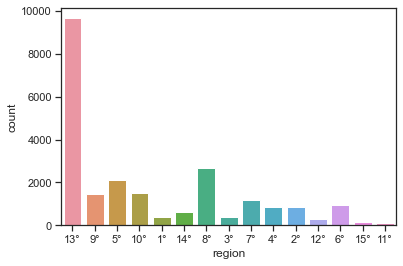

In [20]:
# Region - by using the sns countplot 
print(Counter(df["region"])) # Number of OT per Region
sns.countplot(x='region',data=df);

Region - Unique values: 15
Counter({'13°': 9661, '8°': 2677, '5°': 2127, '10°': 1521, '9°': 1475, '7°': 1174, '6°': 941, '4°': 861, '2°': 838, '14°': 624, '3°': 394, '1°': 392, '12°': 277, '15°': 169, '11°': 127})


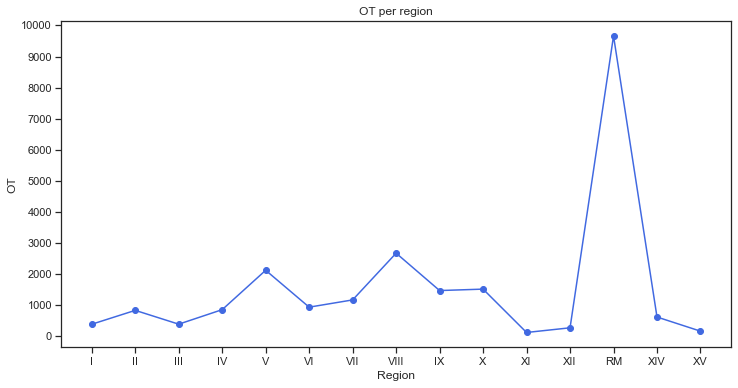

In [21]:
# Region ordered by its proper number according to the geography of Chile
print((f"\033[1mRegion - Unique values: {len(sorted(df['region'].unique()))}\033[0m")) # Region - unique values
region_total = Counter(df["region"]) # Number of OT per Region
print(region_total)
keys_regtotal = [str(int(i))+'°' for i in range(1,16)]
x = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII', 'RM','XIV','XV']
values_regtotal = [region_total[i] for i in keys_regtotal]

plt.rcParams['figure.figsize'] = [12,6]
plt.plot(x,values_regtotal,color = "royalblue", marker = 'o')
plt.title("OT per region")
plt.xlabel("Region")
plt.ylabel("OT")
plt.yticks(list(range(0,10001,1000)))
plt.show()

Estacion - Unique values: 1007
[('OPERACIONES Y SERVICIOS TERPEL LTDA.', 923), ('INVERSIONES ENEX S.A.', 429), ('SOCIEDAD DE COMBUSTIBLES AUSTRAL LTDA.', 159), ('CL - Buses Vule S.A.', 152), ('Petrobras Chile Red Ltda. Salida Norte', 118), ('Petrobras Chile Red Ltda- Enea', 117), ('SOCIEDAD COMERCIAL ANTUCO LTDA.', 115), ('Comercial Albano Ltda.', 108), ('Distribuidora de Combustibles Saavedra y Otro Ltda.', 105), ('DIGESA LTDA.', 105)]


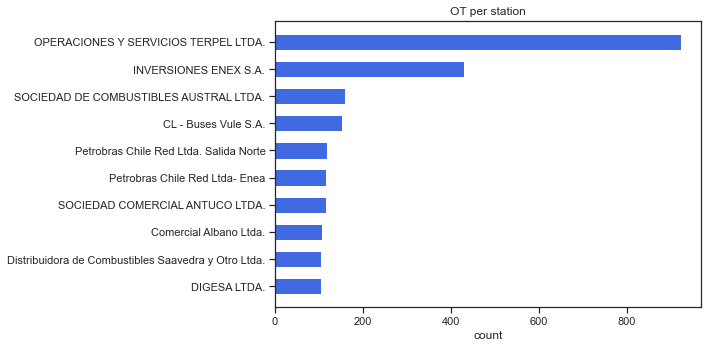

In [22]:
# Estacion - Station
print((f"\033[1mEstacion - Unique values: {len(sorted(df['estacion'].unique()))}\033[0m"))
estacion_total= Counter(df["estacion"])
print(estacion_total.most_common(10)) # Top 10 stations with most OT

dic_est_total = estacion_total.most_common(10)
keys_est_total = [i for i,v in dic_est_total][::-1]
values_est_total = [v for i,v in dic_est_total][::-1]

plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams.update({'figure.autolayout': True})
plt.barh(keys_est_total,values_est_total, align = 'center', color = 'royalblue', height = 0.6)
plt.title("OT per station")
plt.xlabel("count")
plt.show()

Tipos de Falla - Unique values: 66


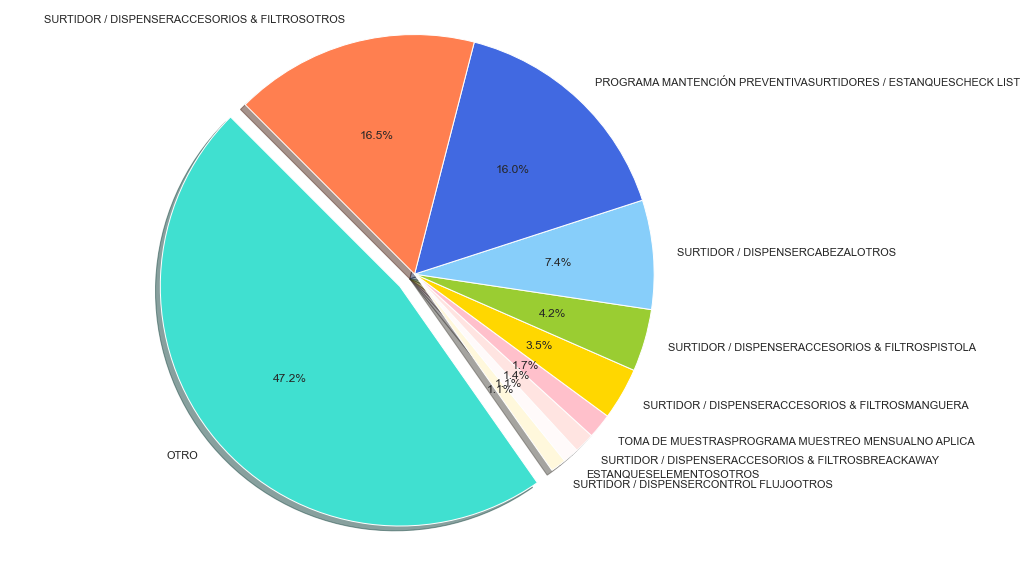

In [23]:
# Tipo de Falla - Type of failure
print((f"\033[1mTipos de Falla - Unique values: {len(sorted(df['tipo_de_falla'].unique()))}\033[0m"))
colors = ['cornsilk','snow', 'mistyrose','pink','gold', 'yellowgreen', 'lightskyblue','royalblue','coral','turquoise']
explode = (0,0,0,0,0, 0, 0, 0, 0, 0.08)  # explode 1st slice
plt.rcParams['figure.figsize'] = [14,8] 
plt.rcParams.update({'figure.autolayout': True})

tfalla_total = Counter(df["tipo_de_falla"])
dic_tfallatotal = tfalla_total.most_common(10)
    
keys = [i for i,v in dic_tfallatotal][::-1]
values = [v for i,v in dic_tfallatotal][::-1]

plt.pie(values,explode = explode, labels = keys, colors = colors,autopct='%1.1f%%', shadow=True, startangle=305)
plt.axis('equal')
plt.show()

In [24]:
# Tipo de Falla - Proportion
pd.DataFrame(df['tipo_de_falla'].value_counts()/ df['tipo_de_falla'].shape[0])

,tipo_de_falla
OTRO,0.437269
SURTIDOR / DISPENSERACCESORIOS & FILTROSOTROS,0.152808
PROGRAMA MANTENCIÓN PREVENTIVASURTIDORES / ESTANQUESCHECK LIST,0.148121
SURTIDOR / DISPENSERCABEZALOTROS,0.068149
SURTIDOR / DISPENSERACCESORIOS & FILTROSPISTOLA,0.038954
...,...
SURTIDOR / DISPENSERMANIFOLDFILTRO,0.000043
SURTIDOR / DISPENSERCONTROL FLUJOTOTALIZADOR,0.000043
SURTIDOR / DISPENSERMEDIDORVALVULA DE RETENCIÒN,0.000043
SURTIDOR / DISPENSERCONTROL FLUJOVALVULA SOLENOIDE / DIGITAL,0.000043


In [25]:
# Observaciones - Observations (an unstructured text column)
df['observacion'][100]

'Brakaway cortado era convencional  Cambio de brakaway 3/4 reconectable boca 3 de 95 el cual se corto y era convencional. Equipo operativo'

In [26]:
# Requerimientos - Requirement (an unstructured text column)
df['requerimiento'][100]

'Area de Atención : En isla Nº 1 boca 3 gasolina 95 manguera  y pistola se salio  del dispensador sin venta isla Nº 1  Solicitado por: Norma Rivera Friz Fono: 82042508'

# III. Data Preparation

#### Business Questions

In order to anwser the business questions from below that we defined at the first step of the CRISP-DM methodology, first it is necessary to pre-process the data

<div class="alert alert-success" style="margin: 20px">
<b>Business Questions: </b><br>
    1.- What are the periods when M&R receives the most number of work orders (OT)? Is there a peak?<br>
    2.- How long does it take to the M&R area to  attend the requests? and how much time does a worker spend fixing the issues?<br>
    3.- What are the most common type of failures or issues that require attention?  
</div>

### Q1. What are the periods when M&R receives the most number of work orders (OT)? Is there a peak?

In [27]:
# Checking again the columns that contains info about dates and times
df.head(3)

,recepcion_ot,hora_recep,ot,estacion,tipo_estacion,ubicacion_tecnica,origen_del_servicio,region,prioridad_sgs,prioridad_cliente,tecnico_asignado,estado_ot,condicion,tipo_de_falla,observacion,requerimiento,tecnico_cierre,tdr,tds,fecha_arribo,hora_arribo,fecha_cierre,hora_cierre,ltr_93,ltr_95,ltr_97,ltr_d,ltr_k,ind_gestion
0,30/08/2019,17:18:00,3008190033,Buses Metropolitana,PUNTO INDUSTRIAL,2256194,Contrato Fuel System Enex,13°,Normal 24 Horas,Normal 24 Horas,Robinson Quiroz,PENDIENTE,ASIGNADA,OTRO,NaN,Area de Atención : Surtidor no marca correctam...,No Asignado,0.00,0.0000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
1,30/08/2019,17:17:00,3008190024,INVERSIONES INGERIASUR LTDA.,ESTACION DE SERVICIO,359,Contrato Fuel System Enex,9°,Normal 24 Horas,Normal 24 Horas,Antonio Lopez,PENDIENTE,ASIGNADA,OTRO,NaN,Area de Atención : TANQUES ENTERRADOS NO CUENT...,No Asignado,0.00,0.0000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
2,30/08/2019,16:52:00,2606190074,Tingaro Spa.,ESTACION DE SERVICIO,553,Contrato Fuel System Enex,13°,Normal 48 Horas,Normal 48 Horas,Juan Aliaga,CERRADA,NO APLICA,OTRO,Se cambia placa de TK 2 GAS95 por placa que in...,Area de Atención : HABILITAR ESTANQUE DE COMB...,No Asignado,-1543.87,-47.8667,27/06/2019,09:00:00,28/08/2019,17:00:00,0.0,0.0,0.0,0.0,0.0,NaN


We notice that these columns have the info we want: **'recepcion_ot', 'hora_recep', 'fecha_arribo', 'hora_arribo', 'fecha_cierre','hora_cierre'**. We can also chech the proper description of each of these columns from the schema above at the step II

In [28]:
# Creating functions that will be used later

# Generating a time interval function (days and weeks)
def days_interval(row):
    '''
    INPUT
    - Row from a dataframe. Diference of days/weeks between the day of the OT reception and the day of the worker arrival
    OUTPUT
    - Time intervals 
    '''
    if row == 0: 
        return '0 - 24 hrs'
    elif row == 1:
        return '1 - 2 days'
    elif row == 2:
        return '2 - 3 days'
    elif row == 3: 
        return '3 - 4 days'
    elif row == 4: 
        return '4 - 5 days'
    elif row == 5: 
        return '5 - 6 days'
    elif row == 6: 
        return '6 - 7 days'
    elif row>= 7 and row <= 14: 
        return '1 - 2 weeks'
    elif row>14 and row <= 21: 
        return '2 - 3 weeks'
    elif row>21 and row <= 31: 
        return '3 - 4 weeks'
    else:
        if row>0:
            return '+ 1 month'
        else: 
            return 'Date Error' 

#---------------------------------------------------------

# Generating a time interval function (mostly hours)       
def hours_interval(row):
    '''
    INPUT
    - Row from a dataframe. Diference of hours/days between the day of the OT reception and the day of the worker arrival
    OUTPUT
    - Time intervals 
    '''
    if row == 0: 
        return 'Less 1 hrs'
    elif row == 1:
        return '1 - 2 hrs'
    elif row == 2:
        return '2 - 3 hrs'
    elif row == 3: 
        return '3 - 4 hrs'
    elif row == 4: 
        return '4 - 5 hrs'
    elif row == 5: 
        return '5 - 6 hrs'
    elif row == 6: 
        return '6 - 7 hrs'
    elif row == 7: 
        return '7 - 8 hrs'
    elif row>=8 and row <= 24: 
        return '8 - 24 hrs'
    elif row>24 and row <= 72: 
        return '1 - 3 days'
    elif row>72 and row <= 168: 
        return '3 - 7 days'
    elif row>168 and row <= 730: 
        return '1 - 4 weeks'
    else:
        if row>0:
            return '+ 1 month'
        else: 
            return 'Time Error'

In [30]:
# Function to extract info from dates and times

def df_date_time(df):
    '''
    INPUT
    - The original Data Frame
    OUTPUT
    - Data Frame adding time intervals columns
    '''
    # Dic for months
    d_months = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}
   
    # To datetime
    df['reception'] = pd.to_datetime((df['recepcion_ot'] + ' ' +  df['hora_recep']), dayfirst= True)  
    df['arrival'] = pd.to_datetime((df['fecha_arribo'] + ' ' +  df['hora_arribo']), dayfirst= True) 
    df['departure'] = pd.to_datetime((df['fecha_cierre'] + ' ' +  df['hora_cierre']), dayfirst= True)
    df['recepcion_ot'] = pd.to_datetime(df['recepcion_ot'], dayfirst= True, format = '%d/%m/%Y')
    df['hora_recep']= pd.to_datetime(df['hora_recep'])
    
    # Adding new columns that contains time info
    df['day'] =  (df[['recepcion_ot']].apply(lambda x: datetime.datetime.strftime(x['recepcion_ot'], '%A'), axis=1))
    df['n_day'] = df['recepcion_ot'].dt.day
    df['month'] = (df['recepcion_ot'].dt.month).apply(lambda x: d_months[x]) +' '+ (df[['recepcion_ot']].apply(lambda x: datetime.datetime.strftime(x['recepcion_ot'], '%y'), axis=1))
    df['hour'] = df['hora_recep'].dt.hour

    # Local Function
    def hours_timestamp(td):
        from math import floor
        return (td.days*24)+(td.seconds//3600)

    # Getting new columns with info needed to answer the Q1
    df['time_reception_arrival'] = (df['arrival'] - df['reception']).dt.days
    df['time_arrival_departure'] = (df['departure'] - df['arrival']).apply(hours_timestamp)
    df['interval_recep_arrival'] = df['time_reception_arrival'].apply(days_interval)
    df['interval_arrival_departure'] = df['time_arrival_departure'].apply(hours_interval)
    
    return df

In [31]:
# Applying the function df_date_time to the data frame 
df2 = df_date_time(df.copy())
df2.head(3)

,recepcion_ot,hora_recep,ot,estacion,tipo_estacion,ubicacion_tecnica,origen_del_servicio,region,prioridad_sgs,prioridad_cliente,tecnico_asignado,estado_ot,condicion,tipo_de_falla,observacion,requerimiento,tecnico_cierre,tdr,tds,fecha_arribo,hora_arribo,fecha_cierre,hora_cierre,ltr_93,ltr_95,ltr_97,ltr_d,ltr_k,ind_gestion,reception,arrival,departure,day,n_day,month,hour,time_reception_arrival,time_arrival_departure,interval_recep_arrival,interval_arrival_departure
0,2019-08-30,2021-07-17 17:18:00,3008190033,Buses Metropolitana,PUNTO INDUSTRIAL,2256194,Contrato Fuel System Enex,13°,Normal 24 Horas,Normal 24 Horas,Robinson Quiroz,PENDIENTE,ASIGNADA,OTRO,NaN,Area de Atención : Surtidor no marca correctam...,No Asignado,0.00,0.0000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,2019-08-30 17:18:00,NaT,NaT,Friday,30,AUG 19,17,NaN,NaN,Date Error,Time Error
1,2019-08-30,2021-07-17 17:17:00,3008190024,INVERSIONES INGERIASUR LTDA.,ESTACION DE SERVICIO,359,Contrato Fuel System Enex,9°,Normal 24 Horas,Normal 24 Horas,Antonio Lopez,PENDIENTE,ASIGNADA,OTRO,NaN,Area de Atención : TANQUES ENTERRADOS NO CUENT...,No Asignado,0.00,0.0000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,2019-08-30 17:17:00,NaT,NaT,Friday,30,AUG 19,17,NaN,NaN,Date Error,Time Error
2,2019-08-30,2021-07-17 16:52:00,2606190074,Tingaro Spa.,ESTACION DE SERVICIO,553,Contrato Fuel System Enex,13°,Normal 48 Horas,Normal 48 Horas,Juan Aliaga,CERRADA,NO APLICA,OTRO,Se cambia placa de TK 2 GAS95 por placa que in...,Area de Atención : HABILITAR ESTANQUE DE COMB...,No Asignado,-1543.87,-47.8667,27/06/2019,09:00:00,28/08/2019,17:00:00,0.0,0.0,0.0,0.0,0.0,NaN,2019-08-30 16:52:00,2019-06-27 09:00:00,2019-08-28 17:00:00,Friday,30,AUG 19,16,-65.0,1496.0,Date Error,+ 1 month


 Now we can see that the columns *'time_reception_arrival', 'time_arrival_departure', 'interval_recep_arrival' and 'interval_arrival_departure'* are part of our original dataframe and it will be very useful for asking the Q1 business question

In [136]:
# Function to check the OT evolution over time
def OT_timeline(df, c = 'lightskyblue', figsize = [15,9], save=False):
    '''
    INPUT
    - Data Frame with time intervals (df2)
    - Color (for charts)
    - Figsize
    - Save
    OUTPUT
    - Figure with four subplots (OT per Month, OT per Day, OT per Day of Week and OT per Hour)
    
    '''
    plt.figure(1)
    plt.rcParams['figure.figsize'] = figsize
    # -----------------------------------------------------------
    plt.subplot(221)
    meses = Counter(df["month"]) # Amount of OT per Month
    mi = ['JUL 18','AUG 18','SEP 18','OCT 18','NOV 18','DEC 18','JAN 19','FEB 19','MAR 19','APR 19','MAY 19','JUN 19','JUL 19', 'AUG 19'] #Months in the df
    mv = [meses[i] for i in mi]
    plt.plot(mi, mv, color = c, marker = 'o')
    plt.title("OT per Month", fontweight= 'bold', fontsize = 10)
    plt.ylabel('count')
    plt.xticks(rotation=30)

    # -----------------------------------------------------------
    plt.subplot(222)
    n_dias = Counter(df['n_day']) # Amount of OT per day (number)
    d4 = n_dias.most_common(31)
    ni = [i for i,v in d4][::-1]
    nv = [v for i,v in d4][::-1]
    plt.bar(ni, nv, align='center', color = c)
    plt.title("OT per Day",fontweight= 'bold', fontsize = 10)
    plt.ylabel('count')
    plt.xlabel('Day')
    plt.xticks(range(1,32))

    # -----------------------------------------------------------
    plt.subplot(223)
    dias = Counter(df["day"]) # Amount of OT per day of the week
    di = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    dv = [dias[i] for i in di]
    plt.plot(di, dv, color = c, marker = 'o')
    plt.title("OT per Day of Week",fontweight= 'bold', fontsize = 10)
    plt.ylabel('count')
    plt.xticks(rotation=0)

    # -----------------------------------------------------------
    plt.subplot(224)
    horas = Counter(df["hour"]) # Amount of OT per hour 
    d3 = horas.most_common(30)
    hi = [i for i,v in d3][::-1]
    hv = [v for i,v in d3][::-1]
    plt.bar(hi, hv, align='center', color = c)
    plt.title("OT per Hour",fontweight= 'bold', fontsize = 10)
    plt.xlabel('Hour')
    plt.ylabel('count')
    plt.xticks(range(0,24)) 
    if save:
        plt.savefig('../images/ot_timeline.jpg', dpi= 200, quality=95)
    plt.tight_layout()

In [33]:
# Function to check the proportion of an unique value in a column
def col_perc_values(col):
    '''It returns the proportion of each of the values in a column'''
    return col.value_counts()/col.shape[0]

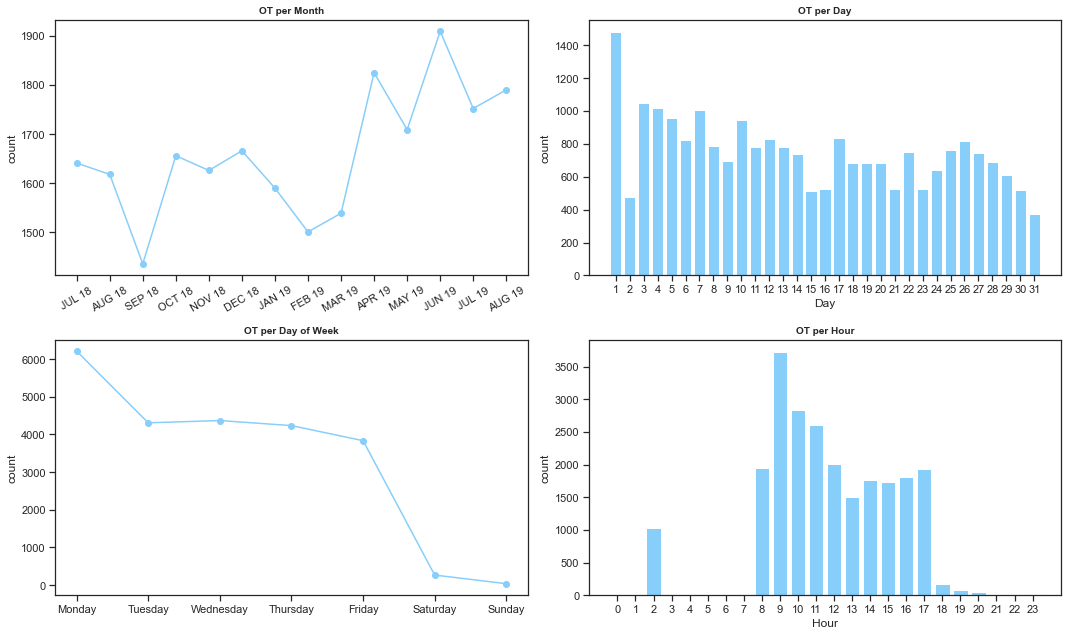

In [138]:
# Checking the output of our OT_timeline function
OT_timeline(df2, save= False)

In [35]:
# Checking the month distribution
col_perc_values(df2['month'])

JUN 19    0.082079
APR 19    0.078468
AUG 19    0.076963
JUL 19    0.075329
MAY 19    0.073480
DEC 18    0.071631
OCT 18    0.071201
JUL 18    0.070556
NOV 18    0.069911
AUG 18    0.069567
JAN 19    0.068364
MAR 19    0.066171
FEB 19    0.064537
SEP 18    0.061742
Name: month, dtype: float64

In [36]:
# Checking the days distribution
col_perc_values(df2['n_day'])

1     0.063677
3     0.045060
4     0.043684
7     0.043297
5     0.041190
10    0.040631
17    0.036031
12    0.035601
6     0.035515
26    0.035128
8     0.033838
11    0.033623
13    0.033580
25    0.032763
22    0.032333
27    0.031946
14    0.031731
9     0.029925
28    0.029753
20    0.029452
19    0.029323
18    0.029280
24    0.027560
29    0.026228
23    0.022659
21    0.022616
16    0.022573
30    0.022272
15    0.022100
2     0.020509
31    0.016123
Name: n_day, dtype: float64

In [37]:
# Checking the days of the week distribution
col_perc_values(df2['day'])

Monday       0.267005
Wednesday    0.187806
Tuesday      0.185227
Thursday     0.182045
Friday       0.164847
Saturday     0.011437
Sunday       0.001634
Name: day, dtype: float64

In [38]:
# Checking the hour distribution
col_perc_values(df2['hour'])

9     0.160246
10    0.121980
11    0.111832
12    0.086379
8     0.083670
17    0.083197
16    0.078124
14    0.076146
15    0.074641
13    0.064709
2     0.044243
18    0.007610
19    0.003784
20    0.001935
23    0.000602
21    0.000473
22    0.000344
1     0.000043
0     0.000043
Name: hour, dtype: float64

#### Q1. Answer

<div class="alert alert-success" style="margin: 20px">
<b>Business Questions: <br><br>
Q1.- What are the periods when M&R receives the most number of work orders (OT)? Is there a peak?</b><br>
    
Looking at the charts from above we can say that:<br>
    
a) The OT (Work Orders) started to become more frequent from April 2019 onwards. On June 2019 was the peak and the lowest point was on September 2018, in part because on this month Chile had its national holidays.<br>
    
b) There is a slight tendency that the number of OT are higher at the beginning of the month, as the first 10 days accumulate 40% of the total.<br>

c) Mondays are the day when M&R recieved the most amount of orders (27% counting the whole week).<br>
    
d) Usually the work orders are received in the morning (beforne 12pm).<br>
    
</div>

### Q2. How long does it take to the M&R area to attend the requests? and how much time does a worker spend fixing the issues?

In [143]:
# Function to check how long does it take to attend the requests

def work_time(df, c = 'lightgray', figsize = [12,9], save= False):
    '''
    INPUT
    - Data Frame with time intervals (df2)
    - Color (for charts)
    - Figsize
    - Save
    
    OUTPUT
    - Figure with two subplots showing the (Time Reception OT / Arrival worker) and (Time Arrival/Departure of the worker)
    
    '''
    plt.figure(1)
    plt.rcParams['figure.figsize'] = figsize
    # -----------------------------------------------------------
    plt.subplot(211)
    recep_arrival = Counter(df['interval_recep_arrival'])
    range_di = ['0 - 24 hrs', '1 - 2 days', '2 - 3 days','3 - 4 days','4 - 5 days','5 - 6 days','6 - 7 days', '1 - 2 weeks',
               '2 - 3 weeks','3 - 4 weeks','+ 1 month','Date Error']
    range_dv = [recep_arrival[i] for i in range_di]

    plt.plot(range_di, range_dv, color = 'green', marker = 'o')
    plt.title("Time Reception OT / Arrival worker",fontweight= 'bold', fontsize = 10)
    plt.ylabel('count')
    plt.xticks(rotation=50)

    # -----------------------------------------------------------
    plt.subplot(212)
    arrival_dep = Counter(df['interval_arrival_departure'])
    range_hi = ['Less 1 hrs', '1 - 2 hrs','2 - 3 hrs','3 - 4 hrs','4 - 5 hrs','5 - 6 hrs','6 - 7 hrs',
              '7 - 8 hrs','8 - 24 hrs','1 - 3 days','3 - 7 days','1 - 4 weeks','+ 1 month','Time Error']
    range_hv = [arrival_dep[i] for i in range_hi]


    plt.bar(range_hi, range_hv, color = 'green', align='center', width = 0.6)
    plt.title("Time Arrival / Departure worker",fontweight= 'bold', fontsize = 10)
    plt.ylabel('count')
    plt.xticks(rotation=50)
    
    if save:
        plt.savefig('../images/ot_work_time.jpg', dpi= 200, quality=95)
    
    plt.tight_layout()

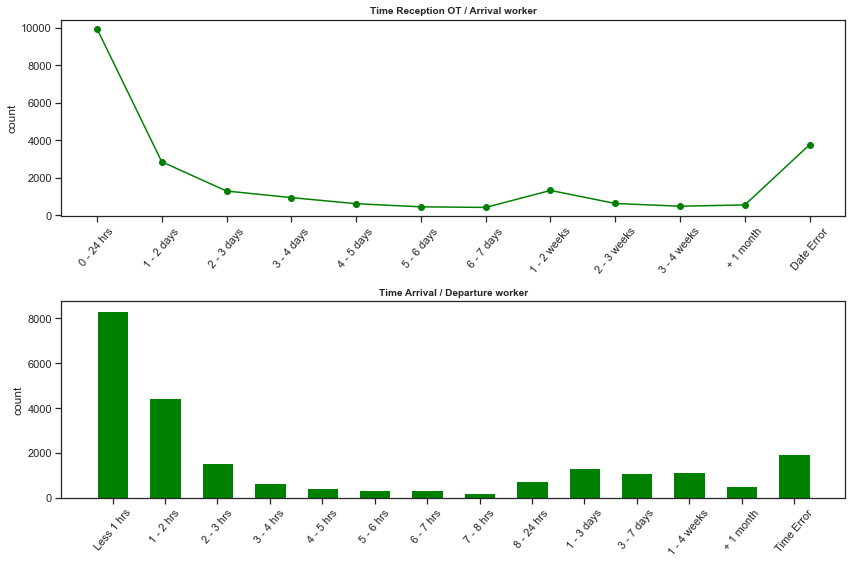

In [147]:
# Checking the output of the function work_time
work_time(df2, figsize = [14,8], save= False)

In [42]:
# Checking the interval_recep_arrival distribution
col_perc_values(df2['interval_recep_arrival'])

0 - 24 hrs     0.427724
Date Error     0.161880
1 - 2 days     0.122538
1 - 2 weeks    0.056884
2 - 3 days     0.055508
3 - 4 days     0.040416
2 - 3 weeks    0.026958
4 - 5 days     0.026486
+ 1 month      0.023648
3 - 4 weeks    0.020724
5 - 6 days     0.019305
6 - 7 days     0.017929
Name: interval_recep_arrival, dtype: float64

In [43]:
# Checking the interval_arrival_departure distribution
col_perc_values(df2['interval_arrival_departure'])

Less 1 hrs     0.358844
1 - 2 hrs      0.192106
Time Error     0.083971
2 - 3 hrs      0.067289
1 - 3 days     0.057787
1 - 4 weeks    0.049402
3 - 7 days     0.047597
8 - 24 hrs     0.032892
3 - 4 hrs      0.029237
+ 1 month      0.021842
4 - 5 hrs      0.019563
5 - 6 hrs      0.015952
6 - 7 hrs      0.014576
7 - 8 hrs      0.008943
Name: interval_arrival_departure, dtype: float64

#### Q2. Answer

<div class="alert alert-success" style="margin: 20px">
<b>Business Questions: <br><br>
Q2.- How long does it take for the M&R area to attend the requests? and how much time does a worker spend fixing the issues?</b>
    
Based on the two plots from above we can conclude that:
    
a) 43% of the time the OT are attended under 24 hours and 55% under 2 days. On the other hand the ratio of OT that get cancelled or are never attended is 16% <br>
    
b) 36% of the time the problem is fixed in a matter of minutes (less than an hour) and 55% under two hours. The Time Error could indicate a manual error when the worker register the activity or that the activity was not solved by him, and this is equial to 8% <br>

    
</div>

### Q3.- What are the most common type of failures or issues that require attention?

In [44]:
# Checking the proportion of Tipo de Falla (Type of Failure) again 
pd.DataFrame(df2['tipo_de_falla'].value_counts()/ df2['tipo_de_falla'].shape[0])

,tipo_de_falla
OTRO,0.437269
SURTIDOR / DISPENSERACCESORIOS & FILTROSOTROS,0.152808
PROGRAMA MANTENCIÓN PREVENTIVASURTIDORES / ESTANQUESCHECK LIST,0.148121
SURTIDOR / DISPENSERCABEZALOTROS,0.068149
SURTIDOR / DISPENSERACCESORIOS & FILTROSPISTOLA,0.038954
...,...
SURTIDOR / DISPENSERMANIFOLDFILTRO,0.000043
SURTIDOR / DISPENSERCONTROL FLUJOTOTALIZADOR,0.000043
SURTIDOR / DISPENSERMEDIDORVALVULA DE RETENCIÒN,0.000043
SURTIDOR / DISPENSERCONTROL FLUJOVALVULA SOLENOIDE / DIGITAL,0.000043


Even though there are 66 types of failures, almost 50% of the data is labeled as OTRO, which means "Other". If we want to extract real information about the issues behind each work order (OT), we need to analyze other columns.

Checking the data frame, there are two unstructured text columns which contain the details of each OT. Those are **"observacion"** and **"requerimiento"**

In [45]:
# Observaciones - Observations
df2['observacion'][250]

'Cambio de destorcedor de 1" a boca n°2 de P. Diesel por estar con filtración. ( uso).\nCambio de pistola de 1" a boca n° 2 de P. Diesel por no cortar se sor automático. ( uso).\nEquipo queda operativo.  Cambio de destorcedor de 1" a boca n°2 de P. Diesel por estar con filtración. ( uso).\nCambio de pistola de 1" a boca n° 2 de P. Diesel por no cortar se sor automático. ( uso).\nEquipo queda operativo.'

In [46]:
# Requerimientos - Requirement 
df2['requerimiento'][250]

'Area de Atención : Filtracion de combustible Solicitado por: Ximena Soto Fono: 33216340'

In [47]:
# Checking nulls again
df2[['observacion', 'requerimiento']].isnull().mean()

observacion      0.060968
requerimiento    0.000000
dtype: float64

In [48]:
# Checking the length of each of these two unstructured text columns 
print(f"Avg length of Obs: {(np.mean(df2['observacion'].apply(str).apply(len)))}")
print(f"Avg length of Req: {(np.mean(df2['requerimiento'].apply(str).apply(len)))}")

Avg length of Obs: 315.93885974718376
Avg length of Req: 87.62107661879783


To find the most common types of failures, mostly the **"observacion"** column will be analyzed, since its average row length is greater than "requerimiento" column and because it is the one written by the technicians at the end of their work, so it contains more technical detail of the work that is completed.

Due to there are some null values at the "observacion" column, our strategy for not losing the row will be impute this null using the value from the "requerimiento" field

In [49]:
# Creating a function to clean text
def word_cleaner(sent):
    '''It returns a sentence that is clean and ready to be processed'''
    import string,re
    from unidecode import unidecode
    text = str(sent).lower() 
    text = re.sub('\d+-\d+-\d+','',text)    # Delete dates DD-MM-YYYY y D-M-YY
    text = re.sub('\d+/\d+/\d+','',text)    # Delete dates DD/MM/YYYY y D/M/YY
    text = re.sub('\d+:\d+', '', text)      # Delete time HH:MM 
    text = re.sub('\S*@\S*\s?','',text)     # Delete emails
    text = re.sub(r'\d{7,9}','', text)      # Delete phone numbers
    text = re.sub('\[.*?¿!¡\]\%', '', text)   # Delete .*?¿!¡\°
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # Delete extra punctuation
    text = re.sub('[%s]' % re.escape('°'), ' ', text)
    text = re.sub('[‘’“”…«»/]', '', text)   # Delete extra punctuation
    text = unidecode(text)                  # Text to unicode (ñ -> n)
    text = re.sub('\n', ' ', text)          # Delete line breaks
    text = re.sub(r'\s{2,}', ' ', text)     # Delete two or more blank spaces
    text = re.sub(r"^\s+", "", text, flags=re.UNICODE)      # Delete two or more blank spaces at beggining
    text = re.sub("^\s+|\s+$", "", text, flags=re.UNICODE)  # Delete two or more blank spaces at ending 
    return text 

In [50]:
# Testing the word_cleaner function  - ORIGINAL TEXT 
print('Cambio de destorcedor de 1" a boca n°2 de P. Diesel por estar con filtración. ( uso).\n¡¿Cambio de pistola de 1" a boca n° 2 de P. Diesel por no cortar se sor automático. ( uso).\nEquipo queda operativo.  Cambio de destorcedor de 1" a boca n°2 de P. Diesel por estar con filtración. ( uso).\nCambio de pistola de 1" a boca n° 2 de P. Diesel por no cortar se sor automático. ( uso).\nEquipo queda operativo.')

Cambio de destorcedor de 1" a boca n°2 de P. Diesel por estar con filtración. ( uso).
¡¿Cambio de pistola de 1" a boca n° 2 de P. Diesel por no cortar se sor automático. ( uso).
Equipo queda operativo.  Cambio de destorcedor de 1" a boca n°2 de P. Diesel por estar con filtración. ( uso).
Cambio de pistola de 1" a boca n° 2 de P. Diesel por no cortar se sor automático. ( uso).
Equipo queda operativo.


In [51]:
# Testing the word_cleaner function  - CLEANED TEXT 
word_cleaner('Cambio de destorcedor de 1" a boca n°2 de P. Diesel por estar con filtración. ( uso).\nCambio de pistola de 1" a boca n° 2 de P. Diesel por no cortar se sor automático. ( uso).\nEquipo queda operativo.  Cambio de destorcedor de 1" a boca n°2 de P. Diesel por estar con filtración. ( uso).\nCambio de pistola de 1" a boca n° 2 de P. Diesel por no cortar se sor automático. ( uso).\nEquipo queda operativo.')

'cambio de destorcedor de 1 a boca n 2 de p diesel por estar con filtracion uso cambio de pistola de 1 a boca n 2 de p diesel por no cortar se sor automatico uso equipo queda operativo cambio de destorcedor de 1 a boca n 2 de p diesel por estar con filtracion uso cambio de pistola de 1 a boca n 2 de p diesel por no cortar se sor automatico uso equipo queda operativo'

In [52]:
# Creating a new DF based on this new function word_cleaner()
df3 = df2.copy()
for col in ['observacion','requerimiento','estacion','tecnico_asignado','tecnico_cierre']:
    df3[col] = df3[col].apply(word_cleaner)

In [53]:
df3[['observacion','requerimiento']].head()

,observacion,requerimiento
0,nan,area de atencion surtidor no marca correctamen...
1,nan,area de atencion tanques enterrados no cuentan...
2,se cambia placa de tk 2 gas95 por placa que in...,area de atencion habilitar estanque de combust...
3,nan,area de atencion sin diesel solicitado por jmz...
4,nan,area de atencion pislota manquera cortada soli...


In [54]:
# Dealing with 'nan/nulls' values and mixing both unstructured text columns into one for not loosing the rows when the observation is null 
df3['text_detail'] = np.where(df3['observacion'] != 'nan', df3['observacion'], df3['requerimiento'])
df3[['observacion','requerimiento','text_detail']].head()

,observacion,requerimiento,text_detail
0,nan,area de atencion surtidor no marca correctamen...,area de atencion surtidor no marca correctamen...
1,nan,area de atencion tanques enterrados no cuentan...,area de atencion tanques enterrados no cuentan...
2,se cambia placa de tk 2 gas95 por placa que in...,area de atencion habilitar estanque de combust...,se cambia placa de tk 2 gas95 por placa que in...
3,nan,area de atencion sin diesel solicitado por jmz...,area de atencion sin diesel solicitado por jmz...
4,nan,area de atencion pislota manquera cortada soli...,area de atencion pislota manquera cortada soli...


In [55]:
# Checking nulls again
print(f"observacion: {df3['observacion'][df3['observacion'] == 'nan'].count()}")
print(f"requerimiento: {df3['requerimiento'][df3['requerimiento'] == 'nan'].count()}")
print(f"text_detail: {df3['text_detail'][df3['text_detail'] == 'nan'].count()}")

observacion: 1418
requerimiento: 0
text_detail: 0


In [56]:
# Exporting the data - df3 into a pkl file
df3.to_pickle('../data/df_clean.pkl')

Because it is really hard to get full knowledge of all of the unstructured text in the **text_detail** column by checking manually all the rows, an unsupervised learning algorithm will be used to extract information. In this sense, a Topic Modeling approach looks perfect to find hidden patterns.

Topic modeling is a method for unsupervised classification of documents, similar to clustering on numeric data, which finds some natural groups of items (topics) even when we’re not sure what we’re looking for.

Topic modeling provides methods for automatically organizing, understanding, searching, and summarizing large electronic archives.
It can help with the following:
- Discovering the hidden themes in the collection.
- Classifying the documents into the discovered themes.
- Using the classification to organize/summarize/search the documents.

LDA (Latent Dirichlet Allocation) is one of the most popular topic modeling methods. Each document is made up of various words, and each topic also has various words belonging to it. The aim of LDA is to find topics a document belongs to, based on the words in it

For more info about it , go and check this post [A Beginner’s Guide to Latent Dirichlet Allocation(LDA)](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2)

# IV. Modeling

### Q3.- What are the most common type of failures or issues that require attention?

As we said above, we will apply the LDA model, which is an unsupervised machine learning techniques to get knowledge from unstructured text as we have

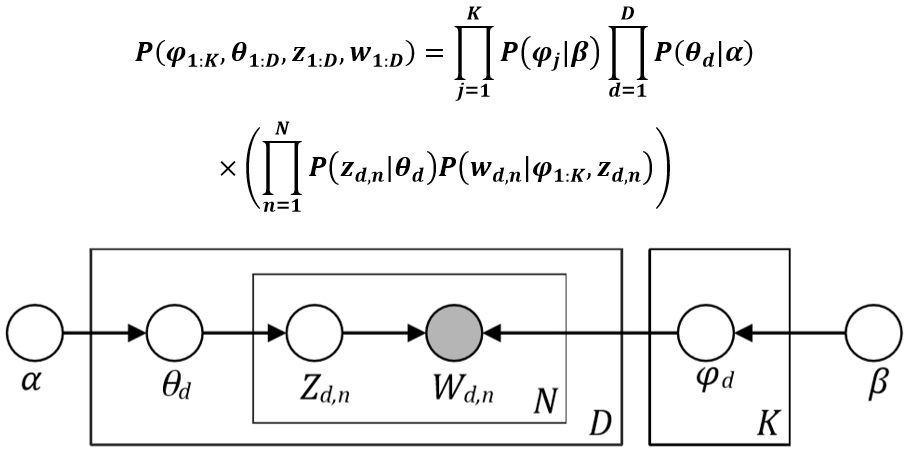

In [57]:
# LDA Model
Image(filename='../images/LDA.png', width=600, height=400)

In [58]:
# Function for getting the inputs that the LDA model will need

def texts_id2word_corpus(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN']):
    '''
    INPUT
    - texts
    - stop_words
    - allowed_postags for the nlp tokenization (using the spacy library)
    OUTPUT
    - texts_out
    - id2word
    - corpus
    '''
    # Tokenization
    texts = [gensim.utils.simple_preprocess(str(sentence),deacc=True,min_len=2,max_len=20) for sentence in texts]
    # Remove stopwords
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # lemmatization
    texts_out = []
    for sent in texts:
        doc = nlp(u" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # Remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc),deacc=True,min_len=2,max_len=20) if word not in stop_words] for doc in texts_out] 
    # Create Dictionary
    id2word = corpora.Dictionary(texts_out)
    # Create Corpus: Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts_out]
    return texts_out,id2word,corpus

In [72]:
# Function that executes and iterates between multiple LDA models. We need multiple models because we will compare them in order to find the best
# We will use the Gensim library for this operation https://radimrehurek.com/gensim/

def coherence_values_gensim(dictionary, corpus, texts, start=2, limit=31, step=2):
    '''
    INPUT
    - dictionary (id2word from the texts_id2word_corpus function)
    - corpus (corpus from the texts_id2word_corpus function)
    - texts (texts from the texts_id2word_corpus function)
    - start (the number of topics K where we want to start)
    - limit (the limit of topics K we will evaluate to find the optimal model)
    - step (Ex: 2 and the topics will be 2,4,6,8, etc)
    OUTPUT
    - model_list (list of each lda model)
    - coherence_values for evaluation
    '''
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary, 
                                                num_topics=num_topics, 
                                                random_state=19960607, 
                                                update_every=1, 
                                                chunksize=1000, 
                                                passes=10, 
                                                alpha='auto', 
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [73]:
# Importing the df we saved from the Data Preparation phase
df_lda = pd.read_pickle('../data/df_clean.pkl')
df_lda.head(3)

,recepcion_ot,hora_recep,ot,estacion,tipo_estacion,ubicacion_tecnica,origen_del_servicio,region,prioridad_sgs,prioridad_cliente,tecnico_asignado,estado_ot,condicion,tipo_de_falla,observacion,requerimiento,tecnico_cierre,tdr,tds,fecha_arribo,hora_arribo,fecha_cierre,hora_cierre,ltr_93,ltr_95,ltr_97,ltr_d,ltr_k,ind_gestion,reception,arrival,departure,day,n_day,month,hour,time_reception_arrival,time_arrival_departure,interval_recep_arrival,interval_arrival_departure,text_detail
0,2019-08-30,2021-07-17 17:18:00,3008190033,buses metropolitana,PUNTO INDUSTRIAL,2256194,Contrato Fuel System Enex,13°,Normal 24 Horas,Normal 24 Horas,robinson quiroz,PENDIENTE,ASIGNADA,OTRO,nan,area de atencion surtidor no marca correctamen...,no asignado,0.00,0.0000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,2019-08-30 17:18:00,NaT,NaT,Friday,30,AUG 19,17,NaN,NaN,Date Error,Time Error,area de atencion surtidor no marca correctamen...
1,2019-08-30,2021-07-17 17:17:00,3008190024,inversiones ingeriasur ltda,ESTACION DE SERVICIO,359,Contrato Fuel System Enex,9°,Normal 24 Horas,Normal 24 Horas,antonio lopez,PENDIENTE,ASIGNADA,OTRO,nan,area de atencion tanques enterrados no cuentan...,no asignado,0.00,0.0000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,2019-08-30 17:17:00,NaT,NaT,Friday,30,AUG 19,17,NaN,NaN,Date Error,Time Error,area de atencion tanques enterrados no cuentan...
2,2019-08-30,2021-07-17 16:52:00,2606190074,tingaro spa,ESTACION DE SERVICIO,553,Contrato Fuel System Enex,13°,Normal 48 Horas,Normal 48 Horas,juan aliaga,CERRADA,NO APLICA,OTRO,se cambia placa de tk 2 gas95 por placa que in...,area de atencion habilitar estanque de combust...,no asignado,-1543.87,-47.8667,27/06/2019,09:00:00,28/08/2019,17:00:00,0.0,0.0,0.0,0.0,0.0,NaN,2019-08-30 16:52:00,2019-06-27 09:00:00,2019-08-28 17:00:00,Friday,30,AUG 19,16,-65.0,1496.0,Date Error,+ 1 month,se cambia placa de tk 2 gas95 por placa que in...


In [74]:
df_lda.shape

(23258, 41)

In [75]:
# Assigning the data to be used as input in a list of sentences
data = [row for row in df_lda['text_detail']]
data[:2]

['area de atencion surtidor no marca correctamente los litros que cargan a los buses solicitado por diego pulido fono',
 'area de atencion tanques enterrados no cuentan con placa de identificacion en canos de descarga solicitado por carlos vidal fono']

In [76]:
%%time
# Getting LDA Inputs through the texts_id2word_corpus fuction created above
texts,id2word,corpus = texts_id2word_corpus(texts = data)

Wall time: 1min 2s


In [77]:
texts[:1]

[['surtidor',
  'marcar',
  'correctamente',
  'litro',
  'cargar',
  'bus',
  'diego',
  'pulido']]

In [78]:
id2word

In [79]:
corpus[:1]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]

In [80]:
%%time
# Generating the LDA models and its coherence values using the coherence_values_gensim function 
model_list1, coherence_values1 = coherence_values_gensim(dictionary=id2word, corpus=corpus,texts=texts,start=2,limit=41,step=2)

Wall time: 17min 25s


In [84]:
'''
# Save the lda models
with open('../data/model_list1.pkl', 'wb') as f:
    pickle.dump(model_list1, f)    
with open('../data/coherence_values1.pkl', 'wb') as f:
    pickle.dump(coherence_values1, f)
# Read the lda models
with open('../data/model_list1.pkl', 'rb') as f:
    model_list1 = pickle.load(f)
with open('../data/coherence_values1.pkl', 'rb') as f:
    coherence_values1 = pickle.load(f)
'''

# V. Evaluation

### Q3.- What are the most common type of failures or issues that require attention?

Choosing the right number of K topics in LDA is an extremely important task because basically defined the optimal model. Choosing a very low K will result in very broad topics, while a high K will result in uninterpretable topics or topics that should have been merged. In this context Topic Coherence is a measure that helps to find the optimal K.

For more info about this Topic Coherence measure, check the following paper: https://ieeexplore.ieee.org/document/8259775 

S. Syed and M. Spruit, "Full-Text or Abstract? Examining Topic Coherence Scores Using Latent Dirichlet Allocation," 2017 IEEE International Conference on Data Science and Advanced Analytics (DSAA), 2017, pp. 165-174, doi: 10.1109/DSAA.2017.61.

Due to we already have our coherence values by using the **coherence_values_gensim** function that we created before , now the next step is to evaluate the results, looking for the best model

### Optimal model

In [149]:
def plot_coherence(cv1, start=2,limit=41,step=2, save=False, figsize = (10,5)):
    '''It returns a chart comparing the diferent coherence values per topic that will be useful for chosing the best model'''
    x = range(start, limit, step) 
    plt.rcParams.update({'figure.figsize':figsize})
    plt.plot(x, cv1 , label = 'LDA Gensim')
    plt.title('LDA Coherence')
    plt.xlabel("Topics")
    plt.ylabel("Coherence score")
    plt.legend()
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha = 0.1)
    if save:
        plt.savefig('../images/plot_coherence.jpg', dpi= 200, quality=95)
    plt.show()

In [190]:
def coherence_summary(cv_gensim, start=2,limit=41,step=2):
    num_topics = list(range(start,limit,step))
    d = {'N_topics': num_topics , 'LDA Gensim': cv_gensim}
    return pd.DataFrame(d)

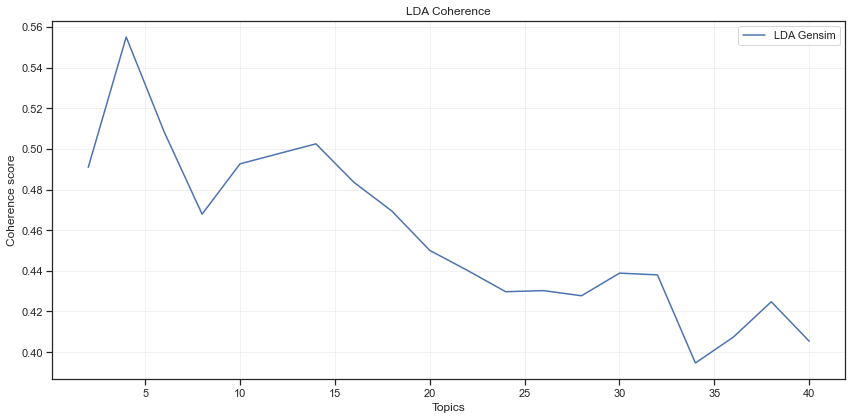

In [192]:
plot_coherence(cv1=coherence_values1,start=2,limit=41,step=2, figsize=(12,6), save = False)

In [194]:
c_summary = coherence_summary(cv_gensim=coherence_values1,start=2,limit=41,step=2)
c_summary

,N_topics,LDA Gensim
0,2,0.490904
1,4,0.555065
2,6,0.508407
3,8,0.467876
4,10,0.492638
5,12,0.497575
6,14,0.502488
7,16,0.483572
8,18,0.469432
9,20,0.450041


In [195]:
'''
# Save as xlsx 
c_summary.to_excel('../data/coherence_summary.xlsx')
'''

In [92]:
# TOP 15 WORDS X TOPIC - LDA GENSIM - K=4
optimal_model = model_list1[1]
pprint(optimal_model.print_topics(num_words=20, num_topics= 100))

[(0,
  '0.060*"cambio" + 0.036*"dispensador" + 0.036*"equipo" + 0.035*"producto" + '
  '0.031*"pistola" + 0.028*"boca" + 0.025*"prueba" + 0.022*"cambiar" + '
  '0.021*"gas" + 0.020*"diesel" + 0.019*"filtro" + 0.017*"surtidor" + '
  '0.015*"lado" + 0.015*"filtracion" + 0.014*"manguera" + 0.013*"valvula" + '
  '0.013*"medidor" + 0.013*"repuesto" + 0.011*"flujo" + 0.011*"mal"'),
 (1,
  '0.029*"estanque" + 0.025*"gas" + 0.024*"diesel" + 0.020*"aguo" + '
  '0.020*"agua" + 0.017*"producto" + 0.017*"litro" + 0.014*"lts" + '
  '0.013*"bomba" + 0.013*"root" + 0.013*"sump" + 0.013*"retirar" + '
  '0.012*"retiro" + 0.012*"veeder" + 0.012*"regla" + 0.010*"linea" + '
  '0.010*"tablero" + 0.010*"tk" + 0.009*"tambor" + 0.009*"electrico"'),
 (2,
  '0.057*"mantencion" + 0.055*"preventivo" + 0.048*"disp" + 0.048*"boca" + '
  '0.043*"calibrar" + 0.035*"tapa" + 0.022*"calibracion" + 0.019*"remplazo" + '
  '0.017*"limpieza" + 0.017*"surtidor" + 0.016*"descarga" + 0.014*"spill" + '
  '0.014*"interior" + 0.0

In [93]:
## GLOBAL MEASURES OF PERFORMANCE - K=4
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.430371425332699

Coherence Score:  0.5550645457079245


In [94]:
# TOP 15 WORDS X TOPIC - LDA GENSIM - K=14
optimal_model = model_list1[6]
pprint(optimal_model.print_topics(num_words=20, num_topics= 100))

[(0,
  '0.107*"cambio" + 0.088*"pistola" + 0.071*"boca" + 0.047*"equipo" + '
  '0.045*"filtracion" + 0.040*"manguera" + 0.036*"medidor" + 0.028*"producto" '
  '+ 0.025*"breakaway" + 0.024*"gas" + 0.023*"repuesto" + 0.022*"swivel" + '
  '0.022*"diesel" + 0.022*"cambiar" + 0.019*"dispensador" + 0.017*"valvula" + '
  '0.015*"mal" + 0.014*"danado" + 0.013*"uso" + 0.013*"proporcional"'),
 (1,
  '0.070*"funda" + 0.066*"ltrs" + 0.063*"instalacion" + 0.051*"adhesivo" + '
  '0.037*"instalar" + 0.035*"fundar" + 0.027*"negro" + 0.027*"petroleo" + '
  '0.025*"vr" + 0.025*"verde" + 0.025*"stock" + 0.024*"camion" + '
  '0.021*"seguridad" + 0.020*"rojo" + 0.019*"petrobra" + 0.019*"pendiente" + '
  '0.018*"grafica" + 0.017*"modelo" + 0.016*"cambio" + 0.015*"faltar"'),
 (2,
  '0.237*"mantencion" + 0.188*"preventivo" + 0.077*"remplazo" + '
  '0.029*"calibracion" + 0.028*"opw" + 0.023*"mes" + 0.020*"rango" + '
  '0.019*"norma" + 0.015*"aire" + 0.015*"ho" + 0.014*"breckawey" + '
  '0.013*"reconectar" + 0.

In [95]:
## GLOBAL MEASURES OF PERFORMANCE - K=14
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.358252740234283

Coherence Score:  0.5024876322835571


According to the LDA Coherence results, the highest point is located when number of topics K is 4 having a **Coherence Score** equal to **0.555** . However the topics are still broad and does not contain enough information about the real problems of the operation.

Based on this, the new approach was to look to the last number of K t before the curve starts to decrease. In this scenario our optimal model is when K is equal to 14, getting a **Coherence Score** equal to **0.502** which is still good if we consider we are dealing with short technical texts about the business operations, moreover they are in Spanish. 

### Topics

In order to better represent the information of these 14 topics and determine their main content of each of them, a series of figures and tables will be generated below.

In [96]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_vis = gensimvis.prepare(optimal_model, corpus, id2word,mds='mmds')
lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.041190  0.068008       1        1  13.624243
11    -0.091202  0.420315       2        1  12.035063
12    -0.214365  0.245554       3        1   9.708638
13    -0.367245  0.213194       4        1   9.295882
6      0.106334  0.352758       5        1   8.984611
8      0.382828  0.120338       6        1   8.447947
4     -0.222886 -0.039333       7        1   7.947080
7      0.097678 -0.277019       8        1   5.648137
10     0.294922  0.309578       9        1   5.192266
9     -0.036390 -0.467221      10        1   5.161668
2     -0.472650 -0.149274      11        1   4.267075
5      0.382597 -0.111208      12        1   3.626216
3      0.352941 -0.341908      13        1   3.457454
1     -0.253753 -0.343780      14        1   2.603720, topic_info=           Term          Freq         Total Category  logprob  loglift
81         boca  10513.000000  10513.000000  Default  30.0000  30.0000
100      equipo  13161.000000  13161.000000  Default  29.0000  29.0000
130  mantencion   5274.000000   5274.000000  Default  28.0000  28.0000
131  preventivo   5115.000000   5115.000000  Default  27.0000  27.0000
65       cambio  13429.000000  13429.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
501    retirado    120.039953    209.983305  Topic14  -4.7282   3.0890
525    vehiculo    110.938997    220.132906  Topic14  -4.8070   2.9630
65       cambio    219.480476  13429.399291  Topic14  -4.1248  -0.4657
518       total    130.293647   1225.303633  Topic14  -4.6462   1.4071
503     tambien     97.192435    570.855754  Topic14  -4.9393   1.8778

[698 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
576       3  0.991104    abierto
3053     11  0.977250      abril
858       1  0.258996  accesorio
858       5  0.145815  accesorio
858       7  0.290242  accesorio
...     ...       ...        ...
271       3  0.995663        wip
624      11  0.995105       wipe
1396      1  0.989371     wipeho
1024      3  0.235680       zona
1024     10  0.762160       zona

[927 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 12, 13, 14, 7, 9, 5, 8, 11, 10, 3, 6, 4, 2])

In [97]:
# Function for finding the Dominant Topic per document (row)

# List of colors
colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#ffe119', '#800000', '#3cb44b', '#808000', '#f58231', '#000075', '#a9a9a9', '#000000','#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#ffe119', '#800000', '#3cb44b', '#808000', '#f58231', '#000075', '#a9a9a9', '#000000']    

# Function to create a data frame that shows the 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords' from the topics founds
def format_topics_sentences(ldamodel, corpus, texts):
    '''
    INPUT
    - ldamodel
    - corpus
    - texts
    OUTPUT
    - data frame that shows the 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords' from the topics founds
    '''    
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [98]:
# Dominant topic and its percentage of contribution in each document

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,12.0,0.4199,"isla, surtidor, motor, cambio, fallar, detecta...","[surtidor, marcar, correctamente, litro, carga..."
1,1,8.0,0.2770,"estanque, aguo, agua, litro, diesel, lts, gas,...","[tanque, enterrado, contar, placa, identificac..."
2,2,13.0,0.4631,"filtro, cambio, flujo, gas, placa, diesel, len...","[cambiar, placa, gas, placa, producto, pintar,..."
3,3,8.0,0.3700,"estanque, aguo, agua, litro, diesel, lts, gas,...","[diesel, jmz]"
4,4,2.0,0.2884,"mantencion, preventivo, remplazo, calibracion,...","[pislota, manquero, cortado, marcela, saavedra]"
5,5,8.0,0.5244,"estanque, aguo, agua, litro, diesel, lts, gas,...","[precencia, aguo, camara, mahole, nivel, impor..."
6,6,8.0,0.3422,"estanque, aguo, agua, litro, diesel, lts, gas,...","[cliente, comentar, agua, interior, estanque, ..."
7,7,1.0,0.3068,"funda, ltrs, instalacion, adhesivo, instalar, ...","[dia, ayer, trabajo, dependecias, encargo, mat..."
8,8,2.0,0.3077,"mantencion, preventivo, remplazo, calibracion,...","[surtidor, entregar, producto, urgente, natali..."
9,9,13.0,0.3629,"filtro, cambio, flujo, gas, placa, diesel, len...","[combustible, tecnico, numeral, cambio, operad..."


In [99]:
# Most representative sentence for each topic

sent_topics_sorteddf_gensim = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_gensim = pd.concat([sent_topics_sorteddf_gensim, grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], axis=0)
    
sent_topics_sorteddf_gensim.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_gensim.columns = ['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'Representative Text']
sent_topics_sorteddf_gensim

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9662,"cambio, pistola, boca, equipo, filtracion, man...","[cambio, manguerar, malla, visto, boca, gasoli..."
1,1.0,0.8753,"funda, ltrs, instalacion, adhesivo, instalar, ...","[pendiente, funda, negro, funda, verde, funda,..."
2,2.0,0.8414,"mantencion, preventivo, remplazo, calibracion,...","[programa, mantencion, preventivo, mes, julio,..."
3,3.0,0.8438,"disp, mal, emitido, preset, teclado, cortado, ...","[bota, dimension, disp, dsl, quebrado, cambio,..."
4,4.0,0.9453,"equipo, despacho, cliente, chequeo, prueba, fa...","[chequeo, equipo, prueba, recirculacion, produ..."
5,5.0,0.9364,"incidencia, ot, reemplazado, pos, uso, cerrar,...","[reemplazado, manguera, pos, perforado, uso, p..."
6,6.0,0.9235,"tapa, limpieza, descarga, chequeo, surtidor, c...","[chequeo, verificacion, surtidor, diesel, veri..."
7,7.0,0.8681,"root, veeder, sensor, presion, fuga, consola, ...","[configuracion, cobsola, veeder, root, ajustar..."
8,8.0,0.9746,"estanque, aguo, agua, litro, diesel, lts, gas,...","[estanque, retirar, agua, estancar, litro, lit..."
9,9.0,0.7945,"electrico, tablero, bomba, trabajo, enex, sume...","[informar, generador, intervenir, sgs, efectua..."


In [154]:
# Function to generate a word cloud for each of the topics 
def word_cloud(lda_model,rows=4, cols=4, figsize = (14,16), save = False):
    '''
    INPUT
    - ldamodel
    - rows (number of rows to display - it should be according to the topics founds)
    - cols (number of columns to display - it should be according to the topics founds)
    - figsize
    - save (if we want to save the plot)
    OUTPUT
    - word cloud per topic rowsxcolumns 
    '''   
    
    # figsize = (width,height)
    cloud = WordCloud(stopwords=stop_words,background_color='white',width=2500,height=1800,max_words=15,colormap='tab10',color_func=lambda *args, **kwargs: colors[i],prefer_horizontal=1.0)
    topics = lda_model.show_topics(formatted=False,num_topics=100,num_words=15)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, sharex=True, sharey=True)

        
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=12), fontweight='bold')
        plt.gca().axis('off')
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout(pad=2)
    if save:
        plt.savefig('../images/word_cloud.jpg', dpi= 200, quality=95)
    plt.show()

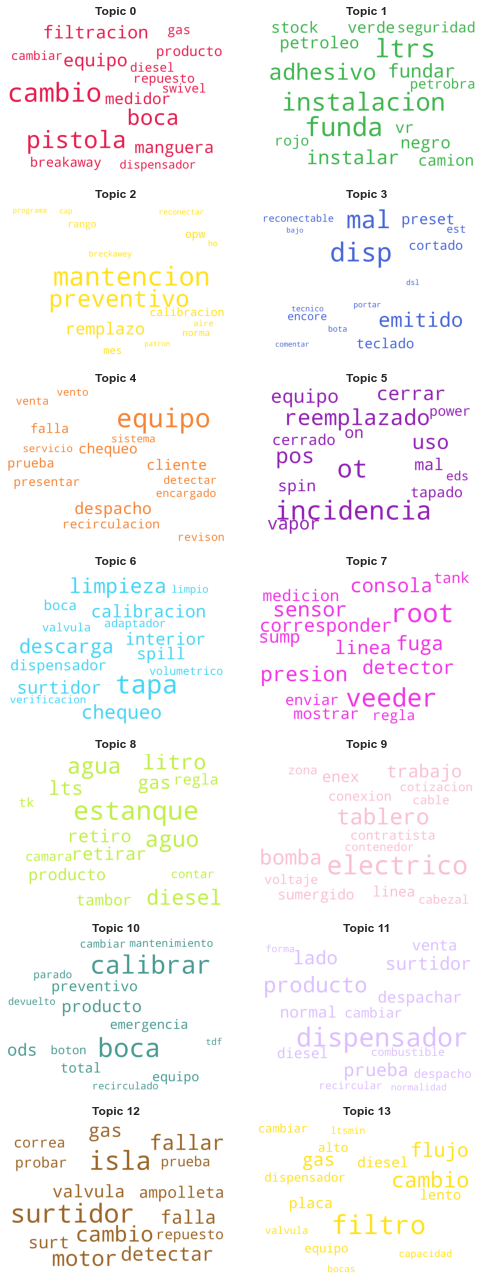

In [159]:
# Word Cloud
word_cloud(lda_model = optimal_model,rows = 7, cols = 2, figsize=(14,18),save = False)

#### Description by topic

Based on the **word cloud** and in the **TOP 15 WORDS X TOPIC - LDA GENSIM - K=14** now we can assign a basic description per topic. This description is also supported by the managers of the M&R division who associated the technical words with business operations

<div class="alert alert-success" style="margin: 20px">
<b>TOPIC DESCRIPTION (ORIGINALLY IN SPANISH): <br><br>
- Topic 0 : Cambios de piezas generales (pistolas, bocas, manguera, medidor, breakaway, swivel, etc) <br>
- Topic 1 : Instalación de fundas y elementos de seguridad en equipos <br>
- Topic 2 : Mantención preventiva <br> 
- Topic 3 : OT mal emitido y problemas menores en equipos<br>
- Topic 4 : Equipos de despacho y ventas a clientes <br>
- Topic 5 : Incidencias de emergencia<br>
- Topic 6 : Tapas de descarga y válvulas<br>
- Topic 7 : Consola Veeder Root y sensores<br>
- Topic 8 : Estanque de agua, gas y de diesel<br>
- Topic 9 : Problemas eléctricos (tablero eléctrico, conexiones, etc)<br>
- Topic 10 : Calibración de bocas y equipos<br>
- Topic 11 : Dispensadores<br>
- Topic 12 : Isla, motor, surtidores<br>
- Topic 13 : Filtros y problemas de filtración<br>
</b></div>

<div class="alert alert-success" style="margin: 20px">
<b>TOPIC DESCRIPTION (TRANSLATED INTO ENGLISH - SOME WORDS ARE PART OF THE BUSINESS SO IT MAY NOT HAVE A PROPER TRANSLATION): <br><br>
- Topic 0 : Replacement of functional components in a gas station (gas pump, hose, gauges, breakaway, swivel, etc.) <br>
- Topic 1 : Installation of covers and safety elements on equipment<br>
- Topic 2 : Preventive maintenance <br> 
- Topic 3 : Work order incorrectly issued and minor equipment problems<br>
- Topic 4 : Dispatch and customer sales equipment <br>
- Topic 5 : Emergency incidents<br>
- Topic 6 : Discharge caps and valves<br>
- Topic 7 : Veeder Root console and sensors<br>
- Topic 8 : Water, gas and diesel tank<br>
- Topic 9 : Electrical problems (electrical board, connections, etc.)<br>
- Topic 10 : Calibration<br>
- Topic 11 : Dispensers<br>
- Topic 12 : Isla, motor, suppliers<br>
- Topic 13 : Filters and filtration problems<br>
</b></div>

### Insights

In [160]:
# Functions to determine the distribution of the word frequency in the documents 

# General length distribution
def plot_freqdist(doc_lens, bins = None, xtick=300, width_text = 0.8, height_text = 0.65, save = False, figsize = (10,7)):
    '''
    INPUT
    - doc_lens (the length per document)
    - bins (how many bins we want to see in the plot - integer)
    - xtick (tick of the x label)
    - width_text, height_text  (position of the measures calculated in the plot)
    - save (if we want to save the plot)
    - figsize
    OUTPUT
    - Distribution of the number of words per document plot
    '''  
    import seaborn as sns
    mean = round(np.mean(doc_lens))
    median = round(np.median(doc_lens))
    stdev = round(np.std(doc_lens))
    oneperc = round(np.quantile(doc_lens, q=0.01))
    nnineperc = round(np.quantile(doc_lens, q=0.99))
    
    plt.figure(figsize=figsize)
    plt.hist(doc_lens, bins = bins, color='royalblue')
    plt.text(width_text, height_text, f'Mean: {mean} \n\nMedian: {median} \n\nStdev: {stdev} \n\n1%ile: {oneperc} \n\n99%ile: {nnineperc}', transform=plt.gca().transAxes)
    plt.gca().set(ylabel='Number of documents', xlabel='Length')
    plt.title('Distribution of the number of words per document')
    sns.kdeplot(doc_lens, color="gray", shade=False, ax=plt.gca().twinx())
    #plt.tick_params(size=16)
    plt.xticks(np.linspace(0,xtick,11))
    plt.xlim(0,xtick)
    if save:
        plt.savefig('../images/freq_dist_total.jpg', dpi= 200, quality=95)
    plt.show()

# Length distribution per topic
def plot_freqdist_topic(doc_lens, bins = None,rows = 8, cols = 2, width_text = 0.76, height_text = 0.68, figsize= (15,40), save = False):
    '''
    INPUT
    - doc_lens (the length per document)
    - bins (how many bins we want to see in the plot - integer)
    - rows (number of rows to display - it should be according to the topics founds)
    - cols (number of columns to display - it should be according to the topics founds)
    - width_text, height_text  (position of the measures calculated in the plot)
    - save (if we want to save the plot)
    - figsize
    OUTPUT
    - Figure with the number of words per document in each topic found 
    '''  
    import seaborn as sns
    fig, axes = plt.subplots(rows,cols,figsize=figsize, sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):    
        df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        
        mean = round(np.mean(doc_lens))
        median = round(np.median(doc_lens))
        stdev = round(np.std(doc_lens))
        
        ax.hist(doc_lens, bins= bins, color=colors[i])
        ax.tick_params(axis='y', labelcolor=colors[i], color=colors[i])
        sns.kdeplot(doc_lens, color='gray', shade=False, ax=ax.twinx())
        ax.set(xlim=(0, 200), xlabel='Length')
        ax.set_ylabel('Number of documents', color=colors[i])
        ax.set_title('Topic '+str(i), fontdict=dict(color=colors[i]))
        ax.set_xticks(np.linspace(0,200,11))
        plt.text(width_text, height_text, f'Mean: {mean} \n\nMedian: {median} \n\nStdev: {stdev}', transform=plt.gca().transAxes)
    fig.tight_layout(pad= 1.2)
    fig.subplots_adjust(top=0.90)
    #plt.xticks(np.linspace(0,200,11))
    if save:
        plt.savefig('../images/freq_dist_total_per_topic.jpg', dpi= 200, quality=95)
    plt.show()

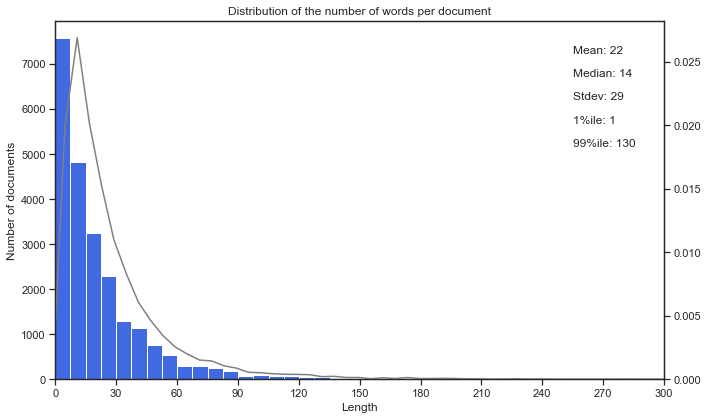

In [161]:
# DISTRIBUCIÓN DE LA FRECUENCIA DE LAS PALABRAS EN LOS DOCUMENTOS 
doc_lens = [len(d) for d in df_dominant_topic.Text]
plot_freqdist(doc_lens, bins = 100, width_text = 0.85, height_text = 0.65,figsize = (10,6), save = False)

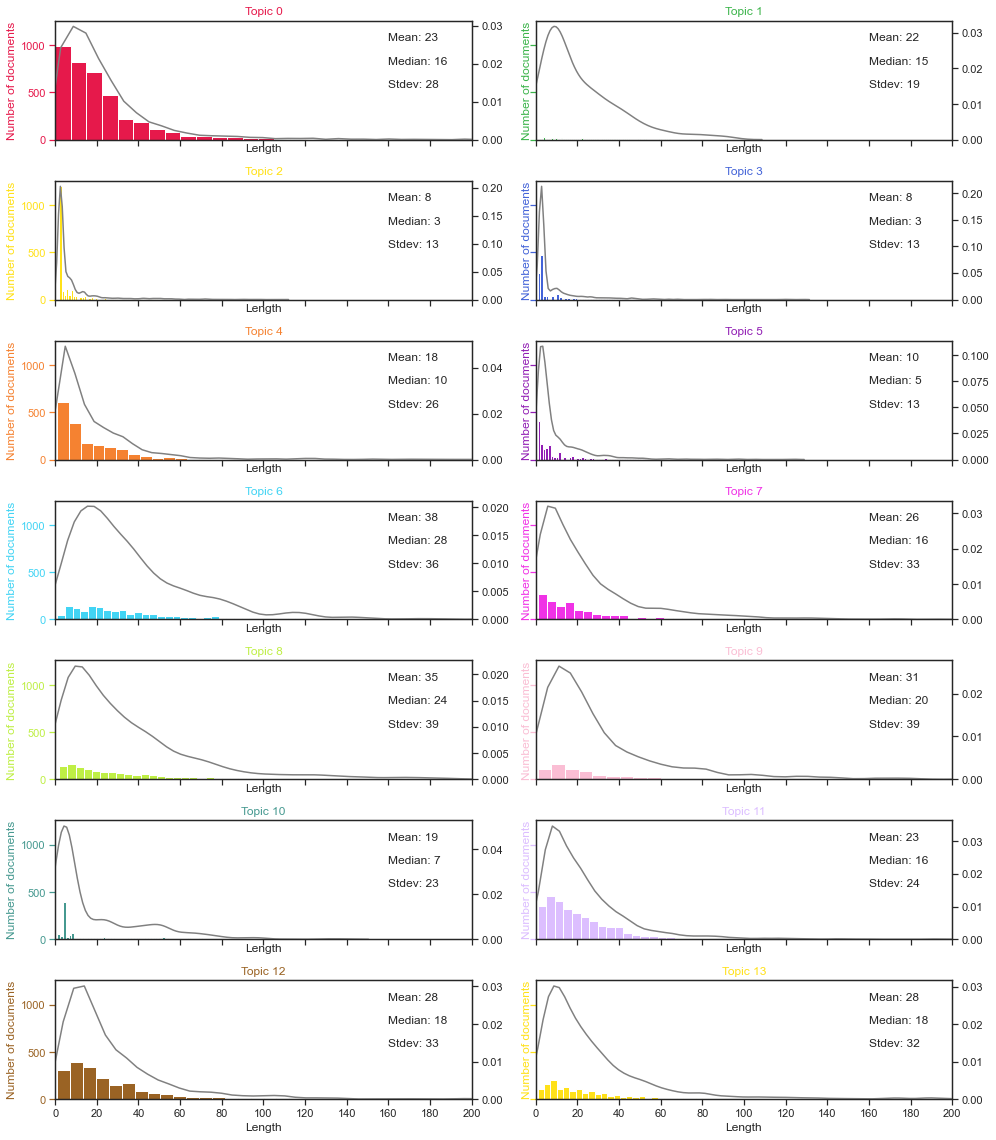

In [162]:
# DISTRIBUCIÓN DE LA FRECUENCIA DE LAS PALABRAS EN LOS TÓPICOS
plot_freqdist_topic(doc_lens,rows = 7, cols = 2, bins = 100,width_text=0.8, height_text= 0.44, figsize = (14,16), save = False)

#### df_topic

In [176]:
# Adding the dominant topic column to the original df

df_topic = df_lda.copy()
df_topic['topico_dominante'] = df_dominant_topic['Dominant_Topic']
df_topic['topico_dominante'] = df_topic['topico_dominante'].astype(int)

In [177]:
'''
# Save df_topic
df_topic.to_pickle('../data/df_topic.pkl')
sent_topics_sorteddf_gensim.to_pickle('../data/sent_topics_sorteddf_gensim.pkl')
# Load df_topic
df_topic = pd.read_pickle('../data/df_topic.pkl')
sent_topics_sorteddf_gensim = pd.read_pickle('../data/sent_topics_sorteddf_gensim.pkl')
'''

"\n# Save df_topic\ndf_topic.to_pickle('../data/df_topic.pkl')\n# Load df_topic\ndf_topic = pd.read_pickle('../data/df_topic.pkl')\n"

In [178]:
df_topic.head(3)

,recepcion_ot,hora_recep,ot,estacion,tipo_estacion,ubicacion_tecnica,origen_del_servicio,region,prioridad_sgs,prioridad_cliente,tecnico_asignado,estado_ot,condicion,tipo_de_falla,observacion,requerimiento,tecnico_cierre,tdr,tds,fecha_arribo,hora_arribo,fecha_cierre,hora_cierre,ltr_93,ltr_95,ltr_97,ltr_d,ltr_k,ind_gestion,reception,arrival,departure,day,n_day,month,hour,time_reception_arrival,time_arrival_departure,interval_recep_arrival,interval_arrival_departure,text_detail,topico_dominante
0,2019-08-30,2021-07-17 17:18:00,3008190033,buses metropolitana,PUNTO INDUSTRIAL,2256194,Contrato Fuel System Enex,13°,Normal 24 Horas,Normal 24 Horas,robinson quiroz,PENDIENTE,ASIGNADA,OTRO,nan,area de atencion surtidor no marca correctamen...,no asignado,0.00,0.0000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,2019-08-30 17:18:00,NaT,NaT,Friday,30,AUG 19,17,NaN,NaN,Date Error,Time Error,area de atencion surtidor no marca correctamen...,12
1,2019-08-30,2021-07-17 17:17:00,3008190024,inversiones ingeriasur ltda,ESTACION DE SERVICIO,359,Contrato Fuel System Enex,9°,Normal 24 Horas,Normal 24 Horas,antonio lopez,PENDIENTE,ASIGNADA,OTRO,nan,area de atencion tanques enterrados no cuentan...,no asignado,0.00,0.0000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,2019-08-30 17:17:00,NaT,NaT,Friday,30,AUG 19,17,NaN,NaN,Date Error,Time Error,area de atencion tanques enterrados no cuentan...,8
2,2019-08-30,2021-07-17 16:52:00,2606190074,tingaro spa,ESTACION DE SERVICIO,553,Contrato Fuel System Enex,13°,Normal 48 Horas,Normal 48 Horas,juan aliaga,CERRADA,NO APLICA,OTRO,se cambia placa de tk 2 gas95 por placa que in...,area de atencion habilitar estanque de combust...,no asignado,-1543.87,-47.8667,27/06/2019,09:00:00,28/08/2019,17:00:00,0.0,0.0,0.0,0.0,0.0,NaN,2019-08-30 16:52:00,2019-06-27 09:00:00,2019-08-28 17:00:00,Friday,30,AUG 19,16,-65.0,1496.0,Date Error,+ 1 month,se cambia placa de tk 2 gas95 por placa que in...,13


In [163]:
# Topic distribution - BARPLOT
def topic_distribution(name, namecol, df_topic,s=111, vplus = 12, fontsize= 10, figsize= (12,10), save = False):
    '''
    INPUT
    - name (it refers to the name of a particular value like a station name - it should be None if we want the general view)
    - namecol (column name)
    - df_topic (data frame that has the dominant_topic column )
    - s (horizontal separation of the text at the end of the bar)
    - vplus (vertical separation of the text at the end of the bar)
    - fontsize 
    - figsize
    - save
    OUTPUT
    - Figure with the distribution of the topics across the entire original data frame
    '''  
    if name!=None and namecol!=None:
        df_topic = df_topic[df_topic[namecol] == name]
    topicos = Counter(df_topic['topico_dominante']) 
    ti = list(f'Topic {i}'for i in range(0,len(topicos)))
    tv = [topicos[i] for i in range(0,len(topicos))]

    ax = plt.subplot(s)
    plt.rcParams.update({'figure.figsize':figsize})
    barlist = ax.barh(ti, tv, align='center', height = 0.5)

    for i, v in enumerate(tv):
        ax.text(v+vplus , i , str(v), color='black', va='center')
    for i in range(0,len(topicos)):
        barlist[i].set_color(colors[i])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    if name!=None and namecol!=None:
        plt.title(f"OT distribution by topic - {namecol} {name}",  fontweight="bold", fontdict={'fontsize':fontsize})
        if save: 
            plt.savefig(f'../images/topic_distribution_barplot_{name}_{namecol}.jpg', dpi= 200, quality=95)
    else: 
        plt.title("OT distribution by topic",  fontweight="bold", fontdict={'fontsize':fontsize})
        if save: 
            plt.savefig('../images/topic_distribution_barplot.jpg', dpi= 200, quality=95)
    plt.show()

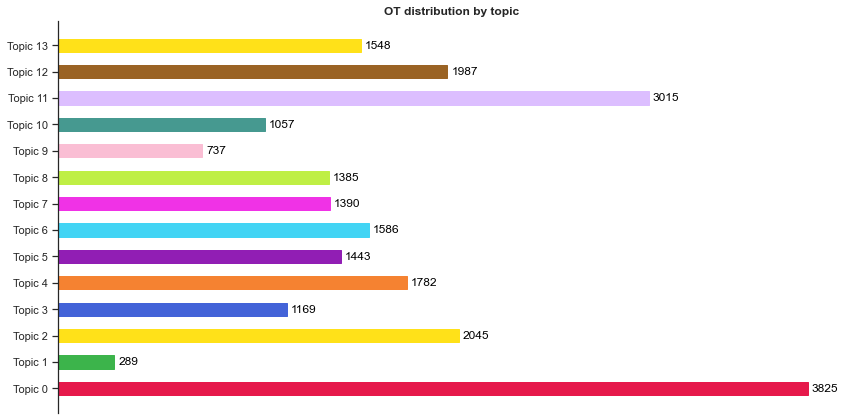

In [164]:
# DISTRIBUCIÓN DE OT POR TÓPICO
topic_distribution(name=None,namecol=None, df_topic=df_topic, vplus = 20,fontsize=12, figsize=(8,6), save = False)

In [189]:
# Proportion of the num_documents per topic
df_topic_distribution = df_topic['topico_dominante'].value_counts().reset_index(name='num_documents')
df_topic_distribution.columns = ['topico_dominante', 'num_documents']
df_topic_distribution['proportion'] = df_topic_distribution['num_documents']/np.sum(df_topic_distribution['num_documents'])
df_topic_distribution.sort_values('proportion', ascending=False)

,topico_dominante,num_documents,proportion
0,0,3825,0.164460
1,11,3015,0.129633
2,2,2045,0.087927
3,12,1987,0.085433
4,4,1782,0.076619
5,6,1586,0.068192
6,13,1548,0.066558
7,5,1443,0.062043
8,7,1390,0.059764
9,8,1385,0.059549


In [197]:
'''
# Save as xlsx 
df_topic_distribution.to_excel('../data/df_topic_distribution.xlsx')
'''

"\n# Save as xlsx \ndf_topic_distribution.to_excel('../data/df_topic_distribution.xlsx')\n"

In [198]:
df_topic.to_excel('../data/df_topic.xlsx')

### Coming back again to the business question Q3 ...

#### Q3. Answer 

<div class="alert alert-success" style="margin: 20px">
<b>Business Questions: <br><br>
Q3.- What are the most common type of failures or issues that require attention?</b>
    
Based on the topic distribution Barplot from above we can conclude that:
    
a) The Topic 0 (Replacement of functional components in a gas station) concentrates 16.5% (3825 documents) of the activities of the M&R division being the main casuistic  <br>
    
b) Next in line are topic 11 (Dispensers), topic 2 (Preventive maintenance) and topic 12 (Isla, motor, suppliers) with 12.9%, 8.79% and  8.54% respectively.  <br>
    
c) On the other hand, the least recurrent topics are 1 (Installation of covers and safety elements on equipment) and 9 (Electrical problems), representing 1.24% and 3.16% of the total number of documents   <br>

d) Unlike at the beginning where the "other" register represented 45% of the "type of failure", we now have a classification of activities much more appropriate to the business operation  <br>
    
</div>

### More Visualization

In [118]:
# KEYWORDS (TEXT)
def keywords_text(topic_nro, df):
    '''It returns the most representative words per topic and its most representative sentence'''
    df = df[df['Topic_Num'] == topic_nro]
    print(f'\033[1mTop 10 words in Topic {topic_nro}\033[0m')
    print([i for i in df['Keywords']])
    print(f'\n\033[1mRepresentative text in Topic {topic_nro}\033[0m')
    print([i for i in df['Representative Text']])

In [119]:
# KEYWORDS (TEXT) in the topic 0
keywords_text(topic_nro=0, df = sent_topics_sorteddf_gensim)

Top 10 words in Topic 0
['cambio, pistola, boca, equipo, filtracion, manguera, medidor, producto, breakaway, gas']

Representative text in Topic 0
[['cambio', 'manguerar', 'malla', 'visto', 'boca', 'gasolin', 'vida', 'util', 'cambio', 'destorcedor', 'filtracion', 'boca', 'gasolin', 'vida', 'util', 'cambio', 'pistola', 'boca', 'gasolin', 'filtrar', 'cano', 'vida', 'util', 'equipo', 'cambio', 'manguerar', 'malla', 'visto', 'boca', 'gasolin', 'vida', 'util', 'cambio', 'destorcedor', 'filtracion', 'boca', 'gasolin', 'vida', 'util', 'cambio', 'pistola', 'boca', 'gasolin', 'filtrar', 'cano', 'vida', 'util', 'equipo']]


In [165]:
# PIE CHARTS - TOP 6 MAIN TOPICS

# Distribution of the 6 main topics in a column - TOP 9 PIE CHARTS
def topics_top9(namecol, df, figsize = (18,14), save = False, angle = 100):
    '''
    INPUT
    - namecol (column name)
    - df (data frame that has the dominant_topic column )
    - figsize
    - save
    - angle (angle of the distribution in the pie plot)
    OUTPUT
    - Pie chart with the distribution of the top 6 topics by a selected column 
    ''' 
    plt.rcParams.update({'figure.figsize':figsize})
    colors2 = ['gold', 'yellowgreen', 'lightskyblue','royalblue','coral','turquoise']
    explode = (0, 0, 0, 0, 0, 0.1)  # explode 1st slice
    
    estacion_total= Counter(df[namecol])
    d = estacion_total.most_common(9)
    keys_est_total = [i for i,v in d][::-1]
    values_est_total = [v for i,v in d][::-1]
    
    for index, est in enumerate(keys_est_total[::-1]):
        df_est = df[df[namecol] == est]
        tfalla_total = Counter(df_est["topico_dominante"])
        dic_tfallatotal = tfalla_total.most_common(6)

        keys = [f'Topic {i}' for i,v in dic_tfallatotal][::-1]
        values = [v for i,v in dic_tfallatotal][::-1]
        plt.subplot(3,3,index+1)
        plt.pie(values,explode = explode, labels = keys, colors = colors2,autopct='%1.1f%%', shadow=True, startangle=angle)
        plt.axis('equal')
        plt.title((f'{index+1}) {est}'), fontweight="bold", fontdict={'fontsize':11})
    if save:
        plt.savefig(f'../images/{namecol}_top_9.jpg', dpi= 200, quality=95)
    plt.show()

    
# Distribution of the 6 main topics in a column - TOP 1 PIE CHART
def topics_top1(name, namecol, df, angle=100,figsize = (18,14), save = False):
    plt.rcParams.update({'figure.figsize':figsize})
    colors2 = ['gold', 'yellowgreen', 'lightskyblue','royalblue','coral','turquoise']
    explode = (0, 0, 0, 0, 0, 0.1)  # explode 1st slice

    df_est = df[df[namecol] == name]
    tfalla_total = Counter(df_est["topico_dominante"])
    dic_tfallatotal = tfalla_total.most_common(6)

    keys = [f'Topic {i}' for i,v in dic_tfallatotal][::-1]
    values = [v for i,v in dic_tfallatotal][::-1]
    plt.pie(values,explode = explode, labels = keys, colors = colors2,autopct='%1.1f%%', shadow=True, startangle=angle)
    plt.axis('equal')
    plt.title((f'{name}'), fontweight="bold", fontdict={'fontsize':12})
    if save:
        plt.savefig(f'../images/{name}_{namecol}.jpg', dpi= 200, quality=95)
    plt.show()

Number of stations: 953


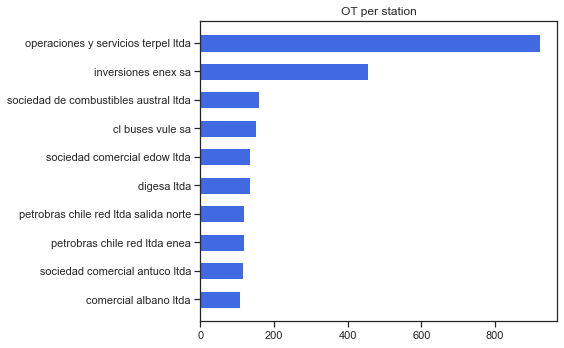

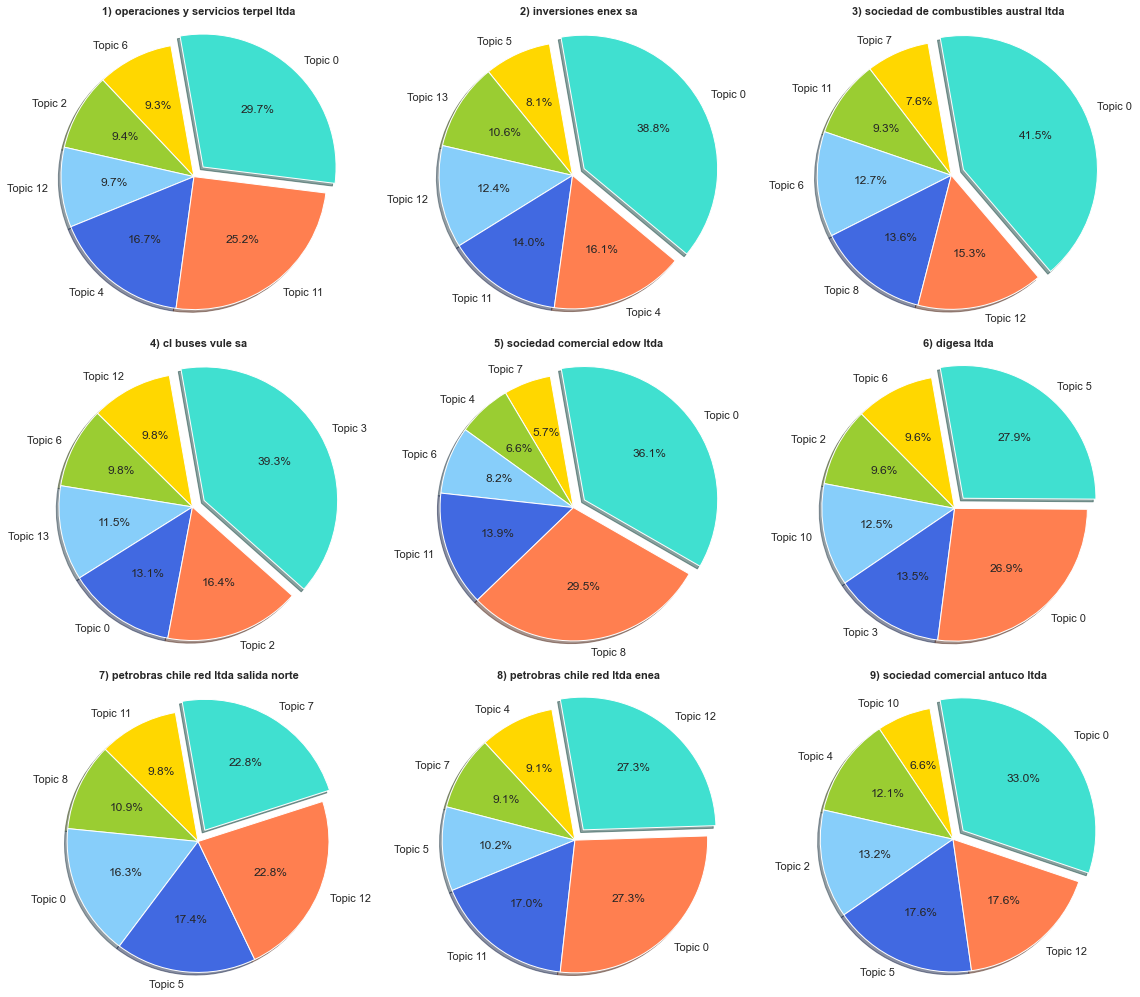

In [167]:
# Distribution of the 6 main topics in the top 9 stations with most work orders (OT)

print((f"\033[1mNumber of stations: {len(sorted(df_topic['estacion'].unique()))}\033[0m"))
estacion_total= Counter(df_topic["estacion"])
dic_est_total = estacion_total.most_common(10)
keys_est_total = [i for i,v in dic_est_total][::-1]
values_est_total = [v for i,v in dic_est_total][::-1]
plt.rcParams.update({'figure.figsize':(8,5)})
plt.barh(keys_est_total,values_est_total, align = 'center', color = 'royalblue', height=0.6)
plt.title("OT per station")
plt.show()
print('\n')

# Applying our topics_top9 function to check the distribution of topics in the stations with most work orders
topics_top9(namecol='estacion', df=df_topic, figsize = (16,14), save=False)

In [168]:
df_topic.head(3)

,recepcion_ot,hora_recep,ot,estacion,tipo_estacion,ubicacion_tecnica,origen_del_servicio,region,prioridad_sgs,prioridad_cliente,tecnico_asignado,estado_ot,condicion,tipo_de_falla,observacion,requerimiento,tecnico_cierre,tdr,tds,fecha_arribo,hora_arribo,fecha_cierre,hora_cierre,ltr_93,ltr_95,ltr_97,ltr_d,ltr_k,ind_gestion,reception,arrival,departure,day,n_day,month,hour,time_reception_arrival,time_arrival_departure,interval_recep_arrival,interval_arrival_departure,text_detail,topico_dominante
0,2019-08-30,2021-07-17 17:18:00,3008190033,buses metropolitana,PUNTO INDUSTRIAL,2256194,Contrato Fuel System Enex,13°,Normal 24 Horas,Normal 24 Horas,robinson quiroz,PENDIENTE,ASIGNADA,OTRO,nan,area de atencion surtidor no marca correctamen...,no asignado,0.00,0.0000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,2019-08-30 17:18:00,NaT,NaT,Friday,30,AUG 19,17,NaN,NaN,Date Error,Time Error,area de atencion surtidor no marca correctamen...,12
1,2019-08-30,2021-07-17 17:17:00,3008190024,inversiones ingeriasur ltda,ESTACION DE SERVICIO,359,Contrato Fuel System Enex,9°,Normal 24 Horas,Normal 24 Horas,antonio lopez,PENDIENTE,ASIGNADA,OTRO,nan,area de atencion tanques enterrados no cuentan...,no asignado,0.00,0.0000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,2019-08-30 17:17:00,NaT,NaT,Friday,30,AUG 19,17,NaN,NaN,Date Error,Time Error,area de atencion tanques enterrados no cuentan...,8
2,2019-08-30,2021-07-17 16:52:00,2606190074,tingaro spa,ESTACION DE SERVICIO,553,Contrato Fuel System Enex,13°,Normal 48 Horas,Normal 48 Horas,juan aliaga,CERRADA,NO APLICA,OTRO,se cambia placa de tk 2 gas95 por placa que in...,area de atencion habilitar estanque de combust...,no asignado,-1543.87,-47.8667,27/06/2019,09:00:00,28/08/2019,17:00:00,0.0,0.0,0.0,0.0,0.0,NaN,2019-08-30 16:52:00,2019-06-27 09:00:00,2019-08-28 17:00:00,Friday,30,AUG 19,16,-65.0,1496.0,Date Error,+ 1 month,se cambia placa de tk 2 gas95 por placa que in...,13


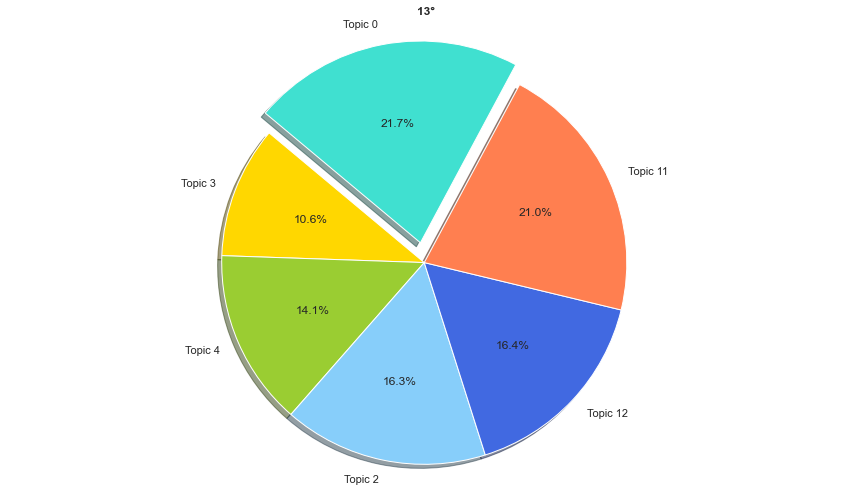

In [169]:
# Right now we can go forward and look the topic distribution of any value in a column
# For example, getting the top 6 topic distribution by region
topics_top1(name= '13°', namecol= 'region', df = df_topic, angle = 140,figsize=(12,7), save=False)

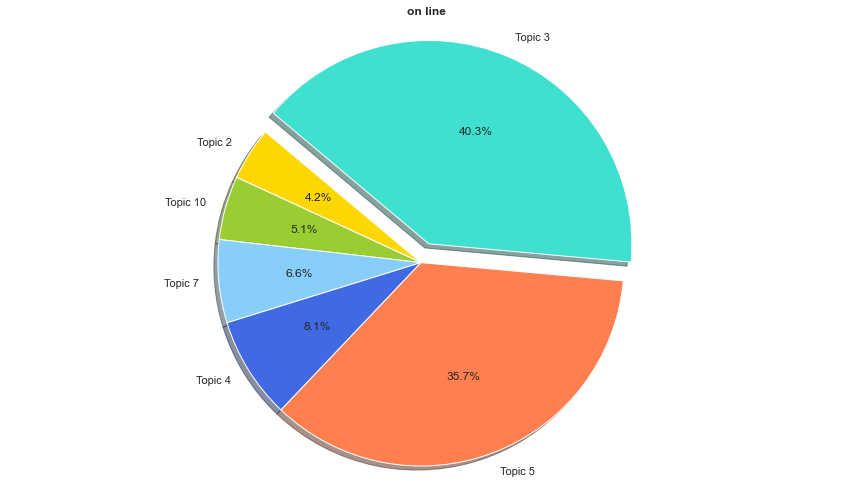

In [170]:
# Or getting the top 6 topic distribution by worker/type of worker
topics_top1(name= 'on line', namecol= 'tecnico_asignado', df = df_topic, angle = 140,figsize=(12,7), save=False)

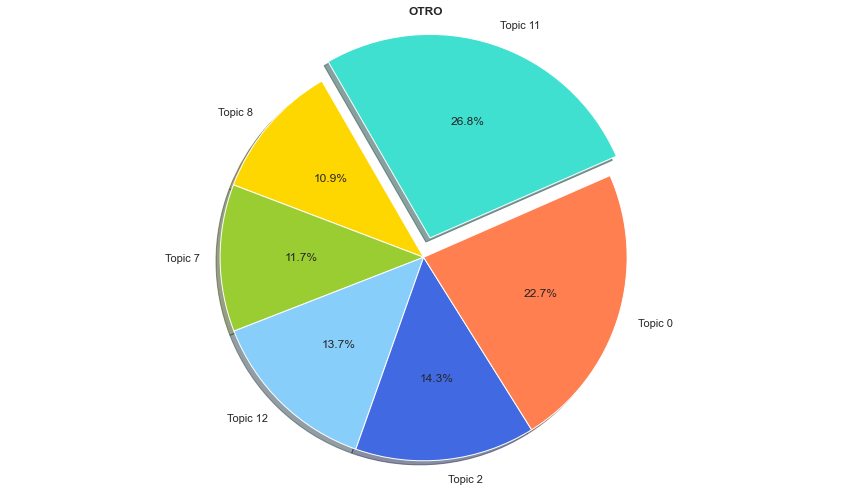

In [200]:
# Or getting the top 6 topic distribution from the original "OTHER" type of failure
topics_top1(name= 'OTRO', namecol= 'tipo_de_falla', df = df_topic, angle = 120,figsize=(12,7), save=False)

#### Q3 Answer - extra complement

<div class="alert alert-success" style="margin: 20px">
<b>Business Questions: <br><br>
Q3.- What are the most common type of failures or issues that require attention?</b>
    
Based on the pie chart from above:<br>
    
e) We can now see that the "other" type of failure that represented almost 50% of the total failures, thanks to our topic model method is now decomposed into several elements, where the 6 main ones are: <br>

 - Topic 11 (Dispensers): 26.8% <br>  
 - Topic 0 (Replacement of functional components in a gas station): 22.7% <br>
 - Topic 2 (Preventive maintenance): 14.3% <br>
 - Topic 12 (Isla, motor, suppliers): 13.7%<br>
 - Topic 7 (Veeder Root console and sensors): 11.7%<br>
 - Topic 8 (Electrical problems): 10.9%<br>
    
</div>

# V. Deployment

The final step of this CRISP-DM methodology is sharing the insights to the stakeholders, or in this case to anyone who wants to understand the results in a easy way.

For this purpose you can check the post on Medium which has an overview about what we have done here.

Thanks!!!!